In [1]:
from pyproj import Proj
import numpy as np
from netCDF4 import Dataset
from scipy.stats import norm
from advectionGP.kernels import EQ
from advectionGP.models.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.wind import WindSimple, RealWindBinned, RealWindNearestNeighbour, RealWindHybrid, FastWindGrid
from advectionGP.sensors import RemoteSensingModel
from advectionGPdatasets import proposeboundary
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# === Step 1: Define UTM and Spatial Domain ===
proj = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
xmin, ymin = proj(140, -39)
xmax, ymax = proj(157, -34)

# === Step 2: Generate Observation Locations ===
# Create evenly spaced 5 x-centers and 10 y-centers in UTM space
x_centers = np.linspace(xmin, xmax, 5)
y_centers = np.linspace(ymin, ymax, 10)

# Set time range for each observation (last 3 hours of the day)
t_start, t_end = 0, 1440
t_start_sec, t_end_sec = 0, 5 *24 *60 *60 #5 Days
sensors = RemoteSensingModel(num_particles=3, t_start=t_start_sec, t_end=t_end_sec)

# Generate obsLocs as [t_start, t_end, x, y] combinations (shape = 50, 4)
obsLocs = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    obsLocs.append([t_start_sec, t_end_sec, x, y])

obsLocs = np.array(obsLocs)

boundary = proposeboundary(obsLocs)
padding = 50000
boundary = (np.array(boundary[0]), np.array(boundary[1]))
boundary[0][1:] -= padding
boundary[1][1:] += padding

# === Step 3: Sensor Model (no longer needs getHs) ===
# sensors = RemoteSensingModel(num_particles=10)

# === Step 4: Setup Kernel & Wind ===
N_feat = 1500
k = EQ(10, 1)
res = [40, 30, 30]
noiseSD = 0.001
k_0 = 0.5
windmodel = FastWindGrid(start_date="2019-12-25", num_days=5)
# windmodel = WindSimple(1, 1)

# === Step 5: Initialize Mesh-Free Model ===
mInfer = Model(
    resolution=res,
    boundary=boundary,
    N_feat=N_feat,
    noiseSD=noiseSD,
    kernel=k,
    sensormodel=sensors,
    windmodel=windmodel,
    k_0=k_0
)

# === Step 6: Generate Regressor Matrix ===
start_time = time.time()
mInfer.computeModelRegressors()
num_obs = mInfer.X.shape[1]
regressor_time = time.time()
print(f"[⏱️] Time to computeModelRegressors(): {regressor_time - start_time:.2f} seconds")

# === Step 7: Generate Synthetic Observations ===
# Load the NetCDF file
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191230.nc4"
dataset = Dataset(file_path, 'r')

from pyproj import Proj, Transformer

# Your UTM projection (Zone 56S)
proj_utm = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
proj_wgs84 = Proj(proj='latlong', datum='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_wgs84)

# Convert all (x, y) to (lon, lat)
sensor_latlons = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    lon, lat = transformer.transform(x, y)
    sensor_latlons.append((lat, lon))

aod_times = dataset.variables['time'][:]
t_index = np.argmin(np.abs(aod_times - t_start))

lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
aod_data = dataset.variables['AODANA'][t_index]  # shape (361, 576)

Y = []
for lat, lon in sensor_latlons:
    lat_idx = np.argmin(np.abs(lats - lat))
    lon_idx = np.argmin(np.abs(lons - lon))
    value = aod_data[lat_idx, lon_idx]
    Y.append(value)

Y = np.array(Y)
Y = np.nan_to_num(Y, nan=0.0)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y) + 1e-6)

# === Step 8: Inference ===
meanZ, covZ = mInfer.computeZDistribution(Y)
inference_time = time.time()
print(f"[⏱️] Time to computeZDistribution(): {inference_time - regressor_time:.2f} seconds")

# === Step 9: Grid Setup for Visualization ===
t_vals = np.linspace(boundary[0][0], boundary[1][0], res[0])
x_vals = np.linspace(boundary[0][1], boundary[1][1], res[1])
y_vals = np.linspace(boundary[0][2], boundary[1][2], res[2])
coords = np.stack(np.meshgrid(t_vals, x_vals, y_vals, indexing='ij'), axis=-1)
coords = coords.reshape(-1, 3)

# === Step 10: Forward Simulation ===
sourcemean, sourcevar, all_samples = mInfer.computeConcentration(
    meanZ=meanZ,
    covZ=covZ,
    Nsamps=1,
    Nparticles=5,
    coords=coords,
    interpolateSource=True
)
forward_time = time.time()
print(f"[⏱️] Time to computeConcentration(): {forward_time - inference_time:.2f} seconds")
# === Total Pipeline Timing ===
print(f"[✅] Total source inference pipeline took {forward_time - start_time:.2f} seconds")

# === Step 11: Plotting ===
# Step setup
sourcemean = sourcemean.reshape(res)
sourcevar = sourcevar.reshape(res)
total_time_seconds = boundary[1][0] - boundary[0][0]
dt_seconds = total_time_seconds / res[0]
base_time = datetime(2019, 12, 25, 0, 0, 0)  # Adjust to your dataset's base time

# # Loop through time steps
# for t_index in range(0, res[0], 5):
#     real_seconds = boundary[0][0] + t_index * dt_seconds
#     real_datetime = base_time + timedelta(seconds=int(real_seconds))
#     timestamp_label = real_datetime.strftime("%Y-%m-%d %H:%M:%S")

#     plt.figure(figsize=(12, 4))
    
#     plt.subplot(1, 2, 1)
#     plt.title(f"Mean Source @ {timestamp_label}")
#     plt.imshow(sourcemean[t_index], origin='lower')
#     plt.colorbar()

#     plt.subplot(1, 2, 2)
#     plt.title(f"Std Source @ {timestamp_label}")
#     plt.imshow(np.sqrt(sourcevar[t_index]), origin='lower')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()



c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: RuntimeWarning: invalid value encountered in cast
  times = ds.variables['time'][:]
c:\users\nur izfarwiza\documents\dissertation\advectiongp\advectionGP\wind.py:560: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  times = ds.variables['time'][:]


✅ Loaded 40 timestamps with shape (40, 11, 28)
Initialising particles...
Diffusing particles...
[⏱️] Time to computeModelRegressors(): 0.65 seconds
Computing SS...
Inverting SS...


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1580130165.py:95: RuntimeWarning: invalid value encountered in cast
  aod_times = dataset.variables['time'][:]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1580130165.py:95: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = dataset.variables['time'][:]


Computing meanZ
Done
[⏱️] Time to computeZDistribution(): 0.46 seconds
Initialising particles...
Particle shape:
(5, 36000, 3)
Diffusing particles...
cache miss, computing source from phi...
Coords NONE!
Computing over coords...
(3, 40, 30, 30)
Computing Source from Phi...
[⏱️] Time to computeConcentration(): 14.62 seconds
[✅] Total source inference pipeline took 15.73 seconds


In [16]:
import pandas as pd
from geopy.distance import geodesic

# Load data
csv_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind\2019_All_sites_air_quality.csv"
df = pd.read_csv(csv_path, usecols=[
    "sample_point_id", "sp_name", "latitude", "longitude",
    "sample_datetime", "param_name", "value", "param_short_name"
])

# Convert date and filter
df['sample_datetime'] = pd.to_datetime(df['sample_datetime'], dayfirst=True)
filtered_df = df[(df['sample_datetime'] >= '2019-12-25') & 
                 (df['sample_datetime'] < '2019-12-31')]

# Filter PM2.5 only
pm25_df = filtered_df[filtered_df['param_short_name'] == 'PM2.5']

# Drop rows without coordinates
pm25_df = pm25_df.dropna(subset=['latitude', 'longitude']).copy()

# Print shape and first few rows
pm25_df.shape, pm25_df.head()


((1150, 8),
         sample_point_id    sp_name   latitude   longitude     sample_datetime  \
 147780            10219  Churchill -38.304314  146.414932 2019-12-25 00:00:00   
 147781            10219  Churchill -38.304314  146.414932 2019-12-25 01:00:00   
 147782            10219  Churchill -38.304314  146.414932 2019-12-25 02:00:00   
 147783            10219  Churchill -38.304314  146.414932 2019-12-25 03:00:00   
 147784            10219  Churchill -38.304314  146.414932 2019-12-25 04:00:00   
 
                          param_name  value param_short_name  
 147780  BAM  Particles < 2.5 micron    2.9            PM2.5  
 147781  BAM  Particles < 2.5 micron   -0.9            PM2.5  
 147782  BAM  Particles < 2.5 micron    0.0            PM2.5  
 147783  BAM  Particles < 2.5 micron    2.4            PM2.5  
 147784  BAM  Particles < 2.5 micron    3.2            PM2.5  )

In [20]:
stations_of_interest = ['Traralgon', 'Morwell East', 'Churchill']
pm25_subset = pm25_df[pm25_df['sp_name'].isin(stations_of_interest)]
print(stations_of_interest)

['Traralgon', 'Morwell East', 'Churchill']


In [24]:
from datetime import date
target_date = date(2019, 12, 25)

pm25_daily = pm25_subset[pm25_subset['sample_datetime'].dt.date == target_date]
# Remove any NaN or negative PM2.5 values
pm25_daily = pm25_daily[pm25_daily['value'].notna() & (pm25_daily['value'] > 0)]

print(pm25_daily)

        sample_point_id    sp_name   latitude   longitude     sample_datetime  \
147780            10219  Churchill -38.304314  146.414932 2019-12-25 00:00:00   
147783            10219  Churchill -38.304314  146.414932 2019-12-25 03:00:00   
147784            10219  Churchill -38.304314  146.414932 2019-12-25 04:00:00   
147785            10219  Churchill -38.304314  146.414932 2019-12-25 05:00:00   
147786            10219  Churchill -38.304314  146.414932 2019-12-25 06:00:00   
...                 ...        ...        ...         ...                 ...   
730794            10011  Traralgon -38.194283  146.531464 2019-12-25 19:00:00   
730805            10011  Traralgon -38.194283  146.531464 2019-12-25 20:00:00   
730816            10011  Traralgon -38.194283  146.531464 2019-12-25 21:00:00   
730827            10011  Traralgon -38.194283  146.531464 2019-12-25 22:00:00   
730838            10011  Traralgon -38.194283  146.531464 2019-12-25 23:00:00   

                         pa

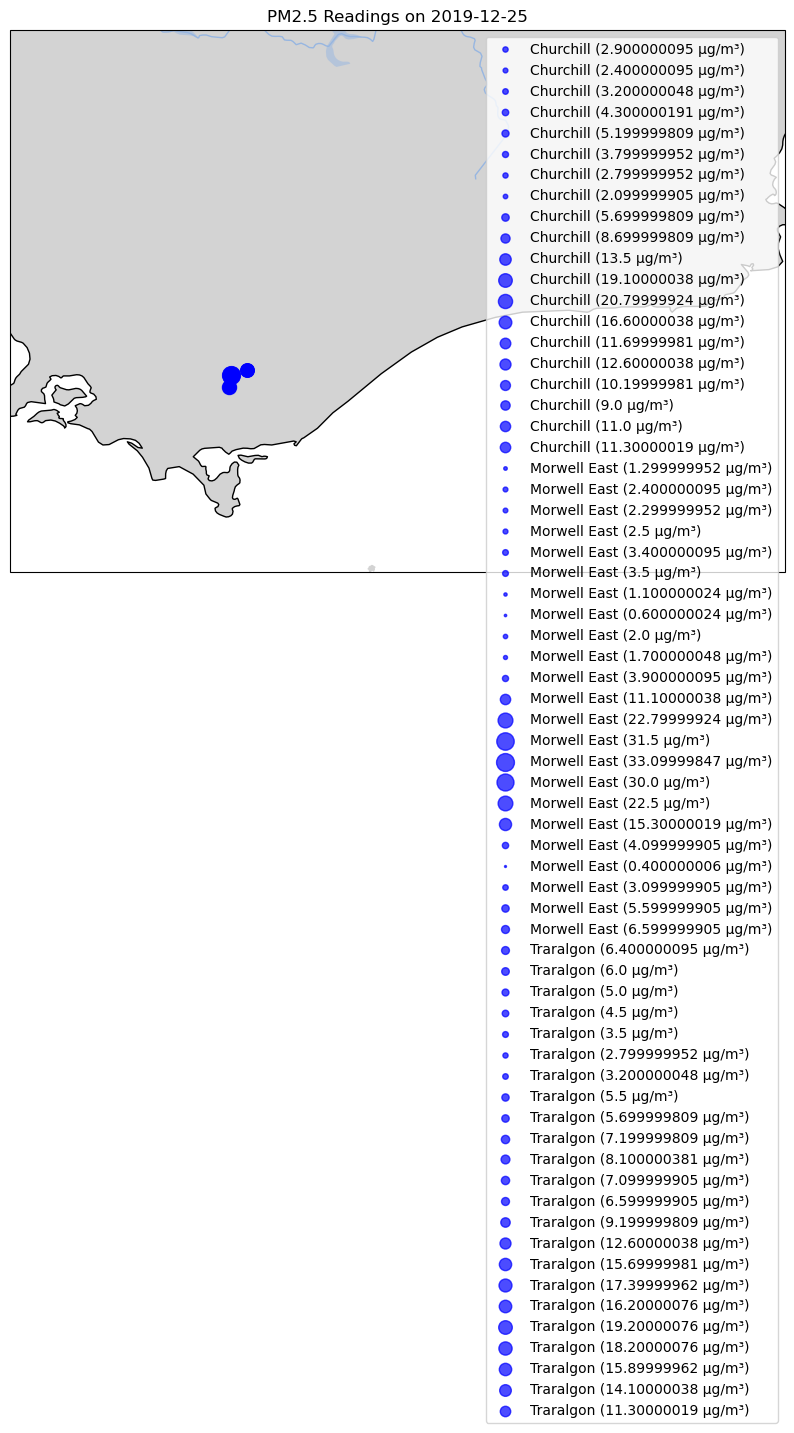

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the map
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([145, 150, -39.5, -36])  # Adjust as needed to focus on Victoria

# Add features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot each PM2.5 reading as a bubble
for _, row in pm25_daily.iterrows():
    ax.scatter(row['longitude'], row['latitude'],
               s=row['value'] * 5,  # scale size by PM2.5
               color='blue', alpha=0.7,
               transform=ccrs.PlateCarree(),
               label=f"{row['sp_name']} ({row['value']} µg/m³)")

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper right')

ax.set_title(f"PM2.5 Readings on {target_date}")
plt.show()


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: RuntimeWarning: invalid value encountered in cast
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: RuntimeWarning: invalid value encountered in cast
  wind_times = ds_wind.variables["time"][:]  # in hours
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  wind_times = ds_wind.variables["time"][:]  # in hours


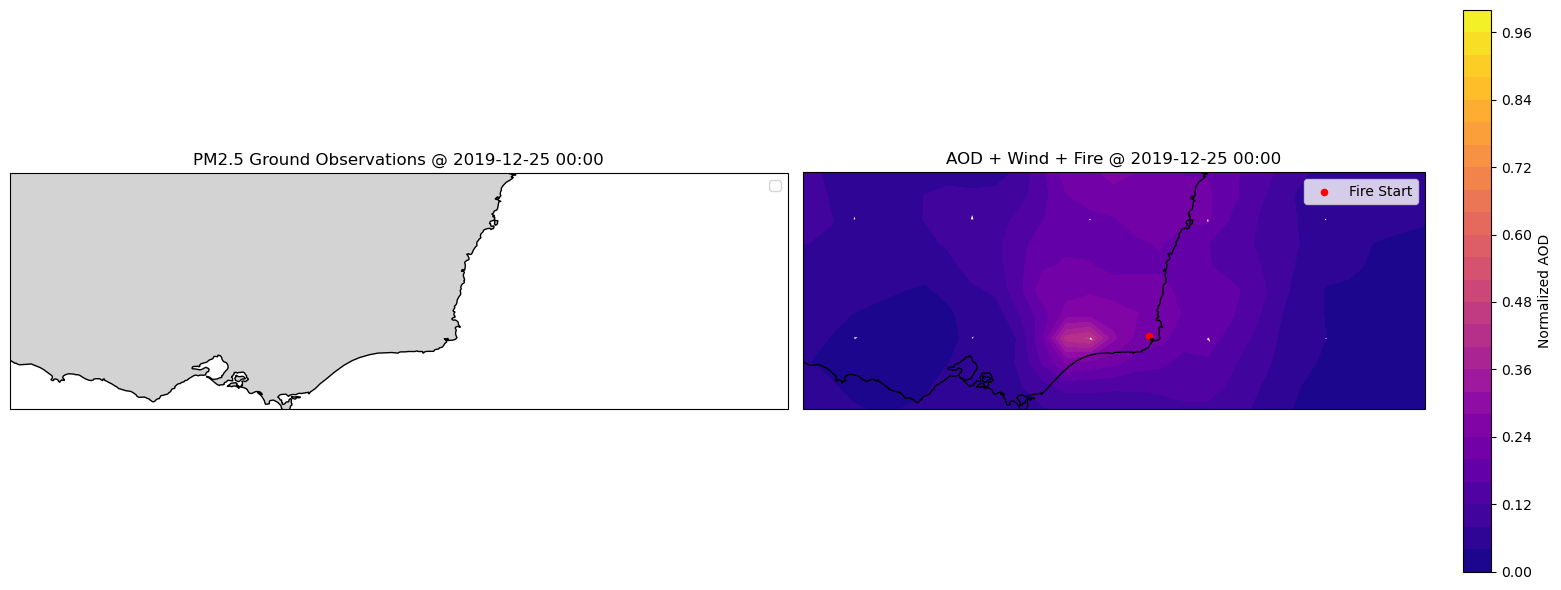

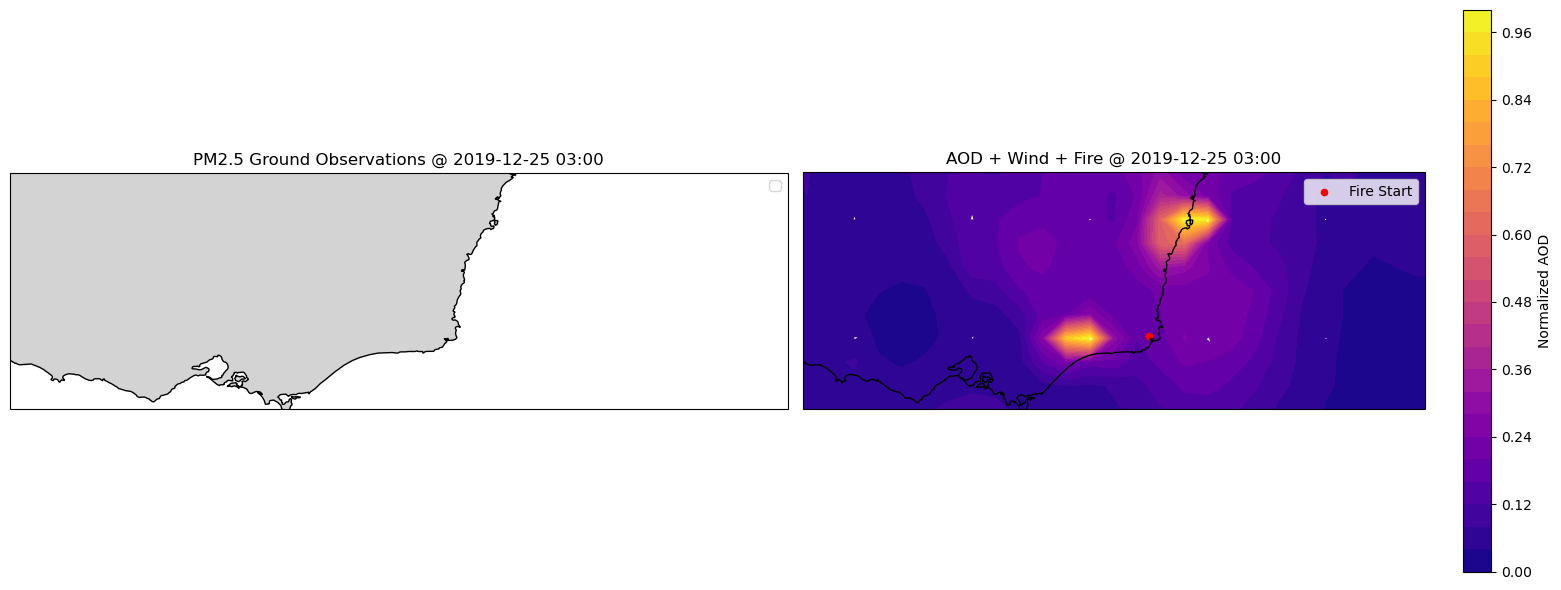

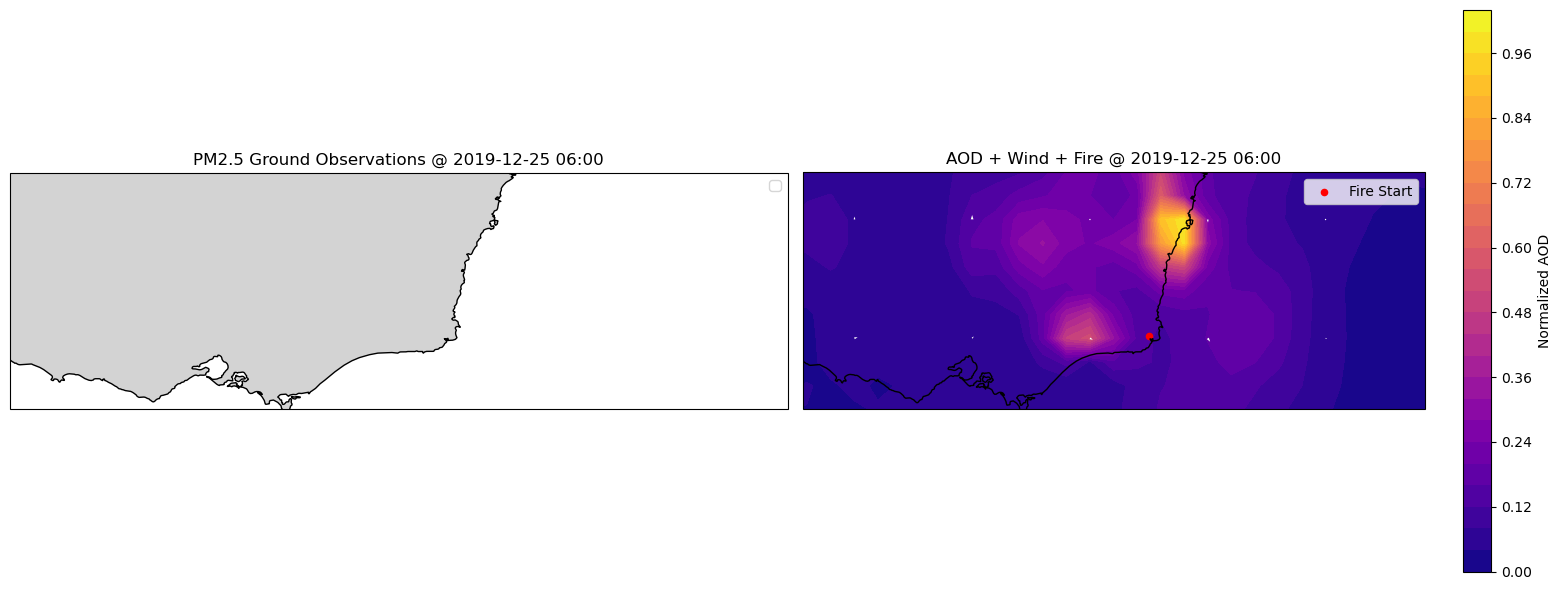

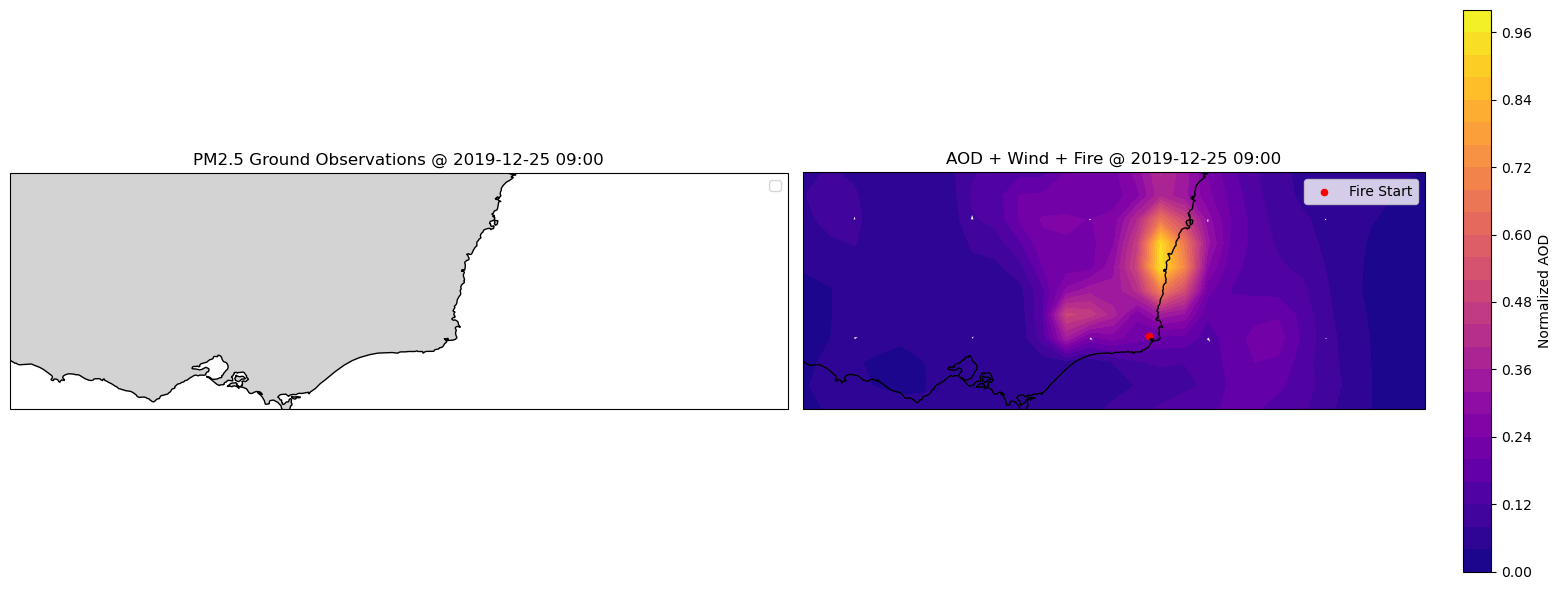

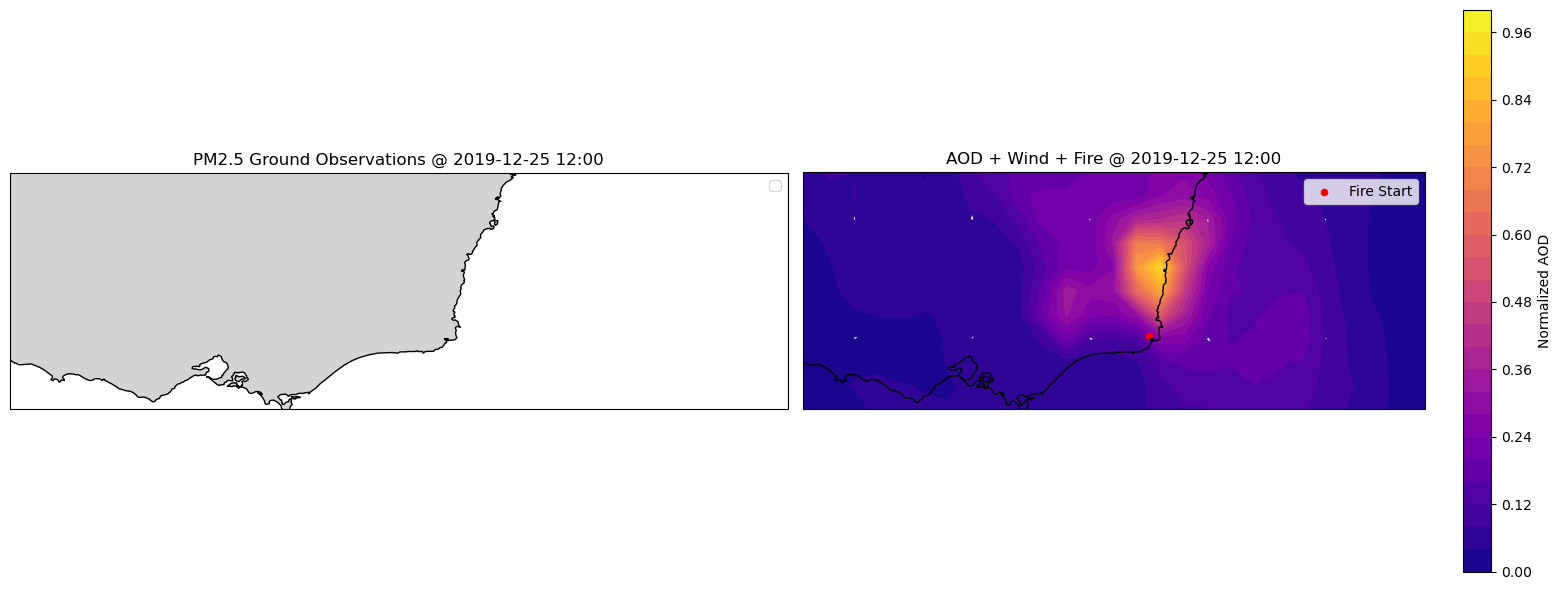

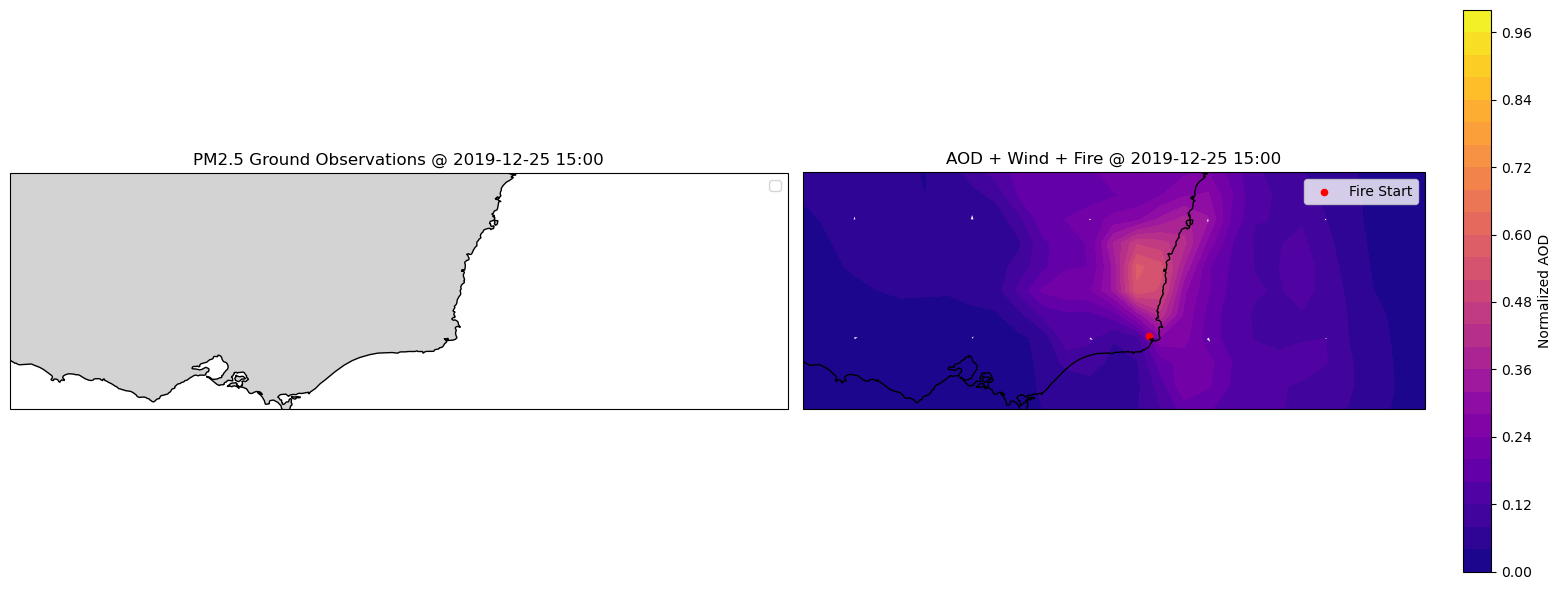

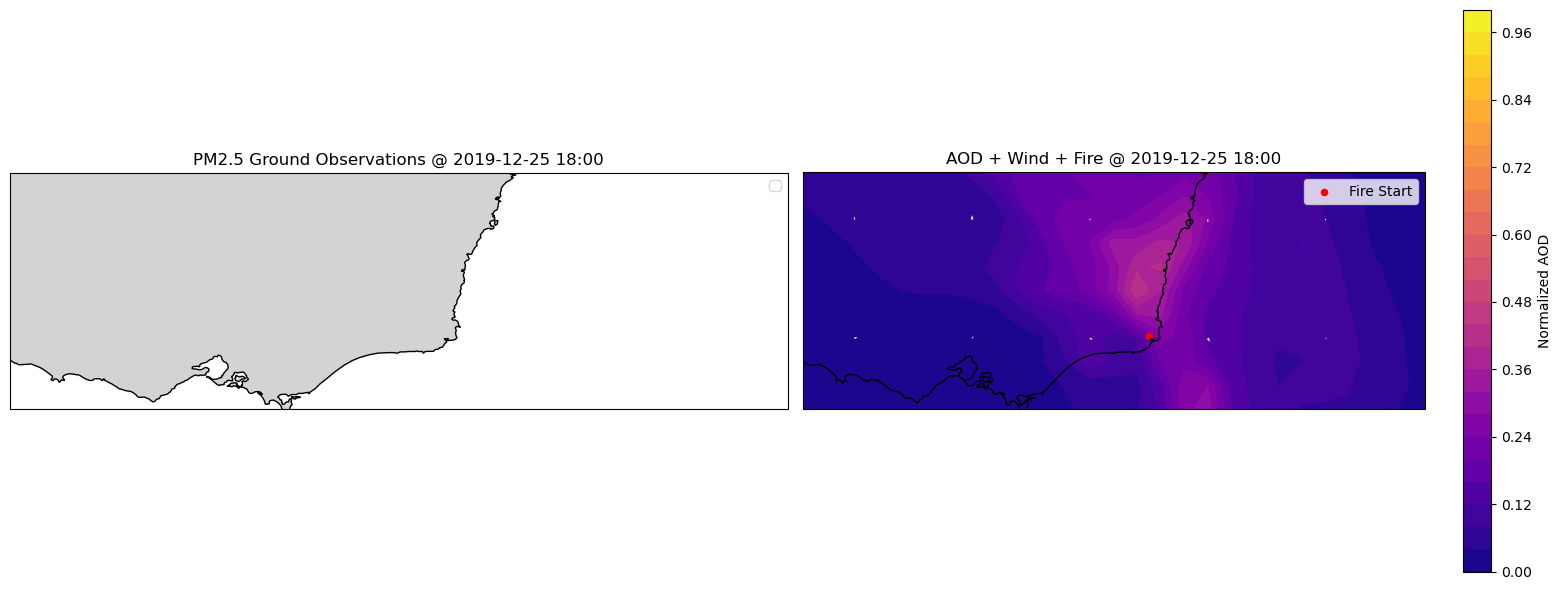

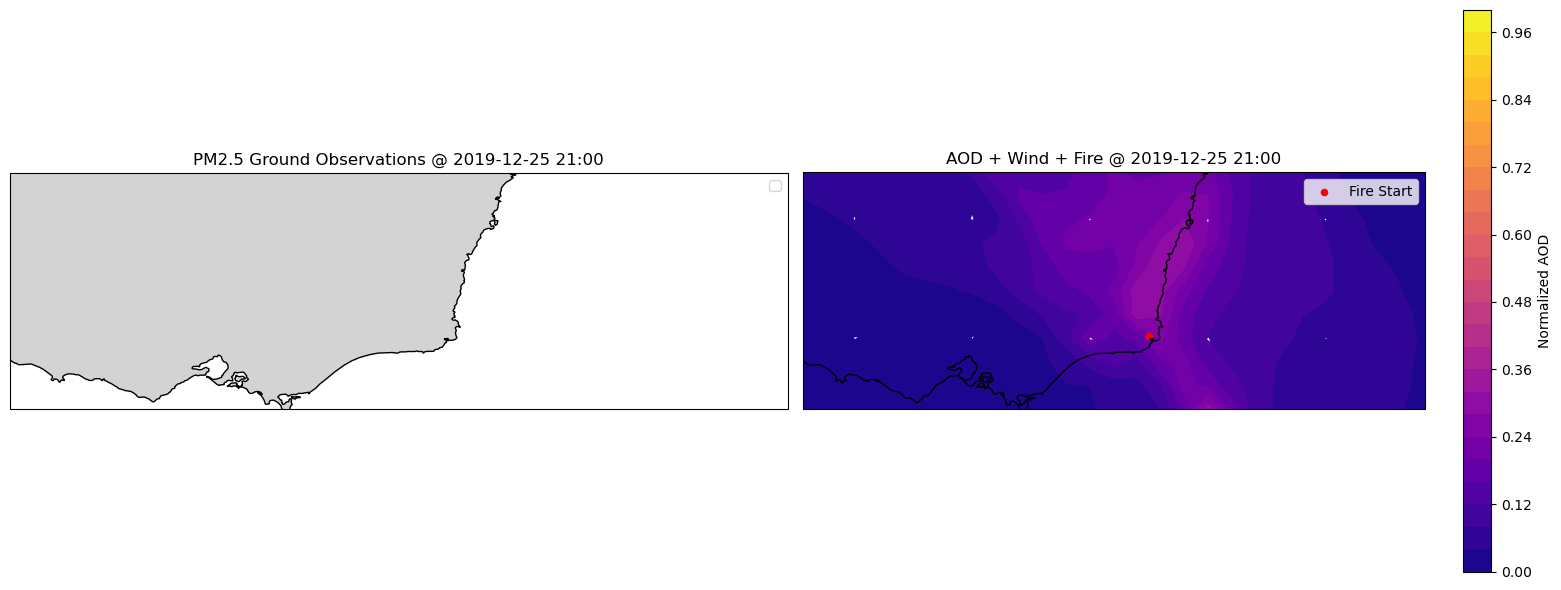

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: RuntimeWarning: invalid value encountered in cast
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: RuntimeWarning: invalid value encountered in cast
  wind_times = ds_wind.variables["time"][:]  # in hours
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  wind_times = ds_wind.variables["time"][:]  # in hours


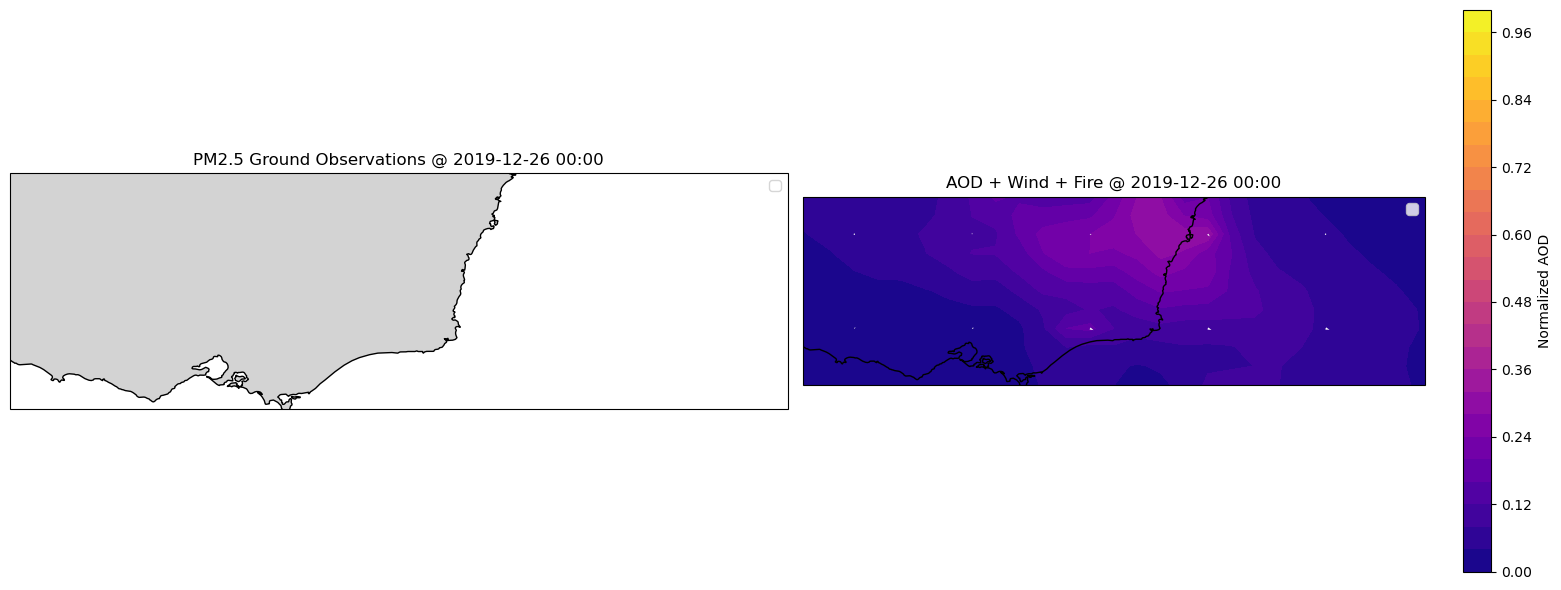

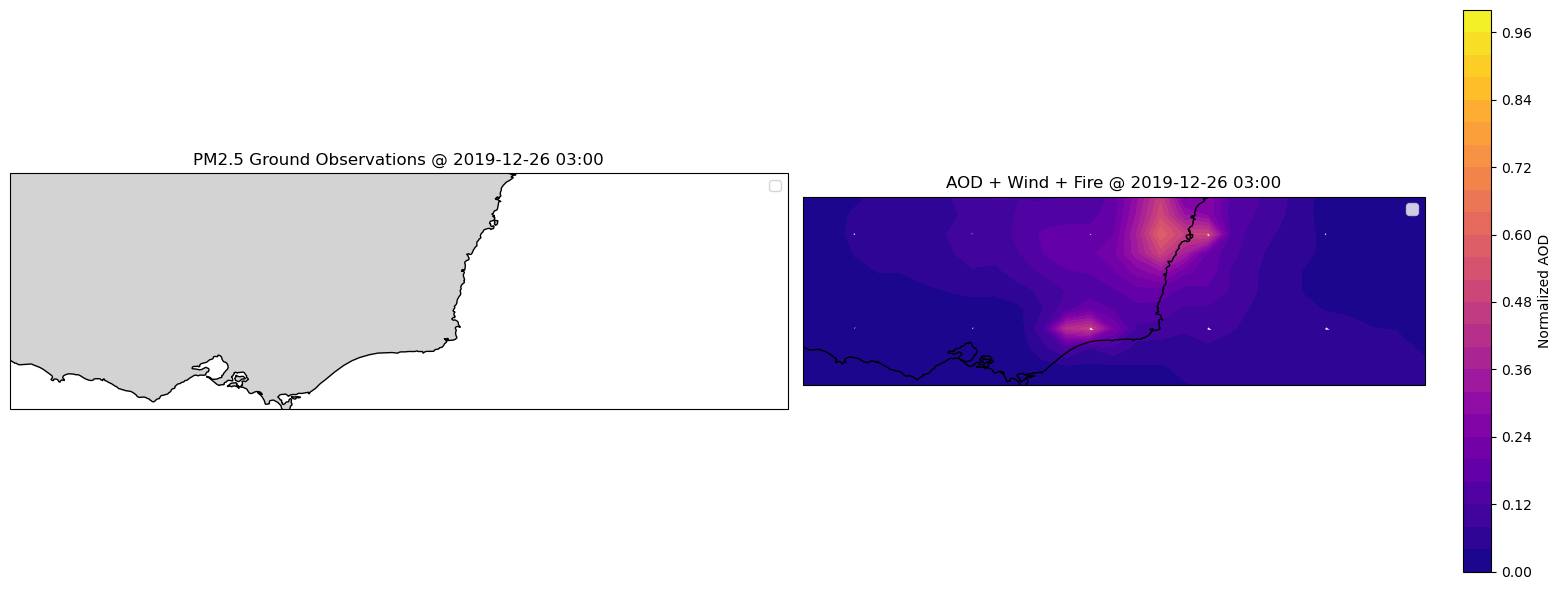

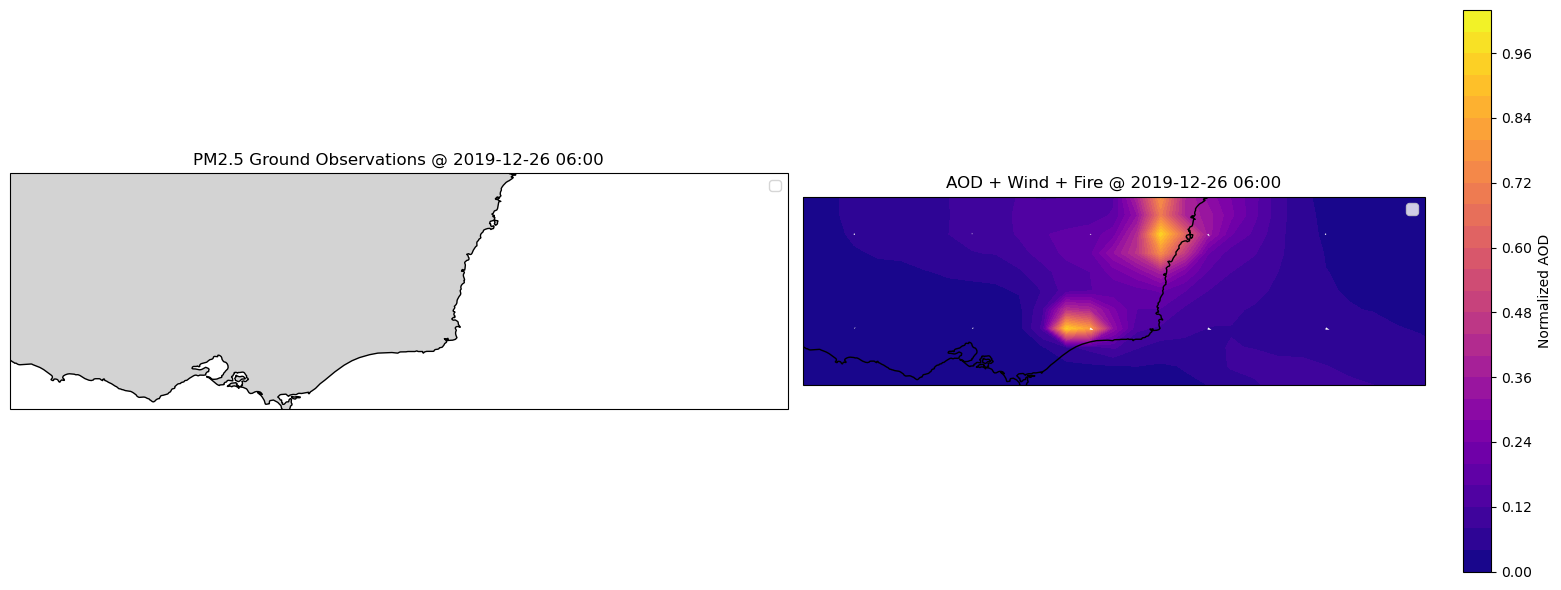

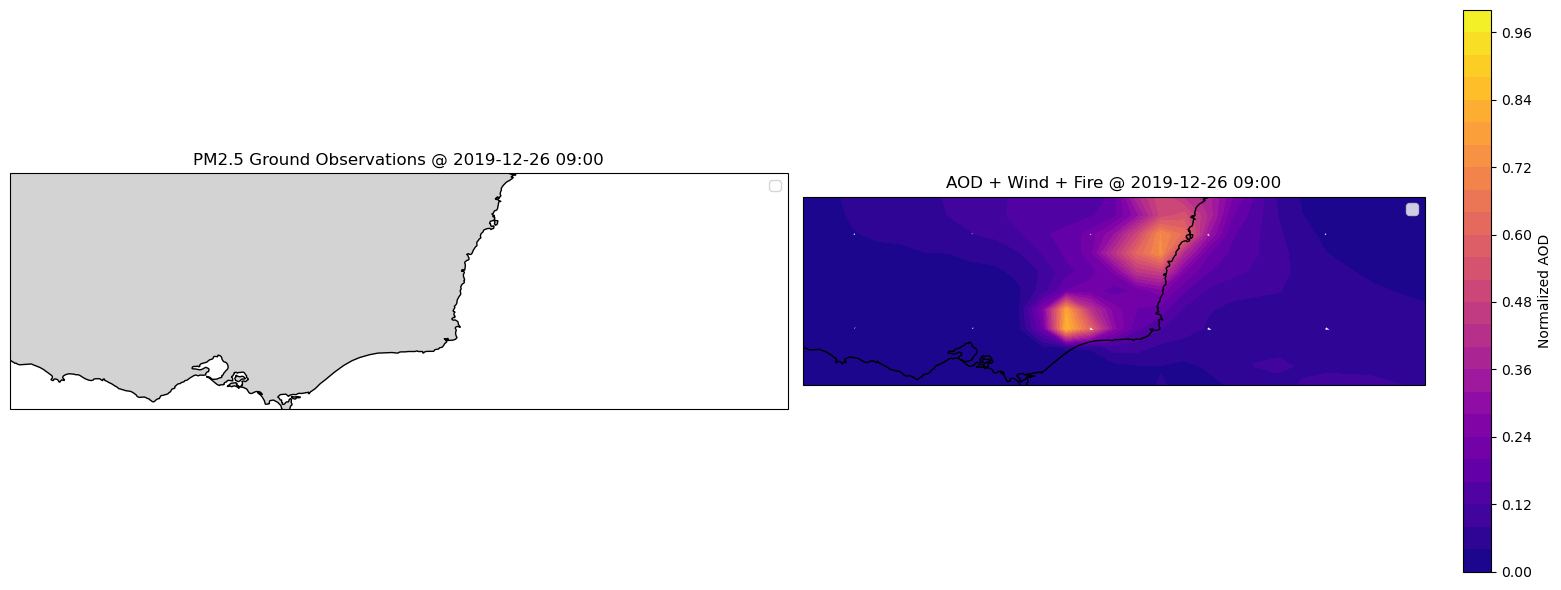

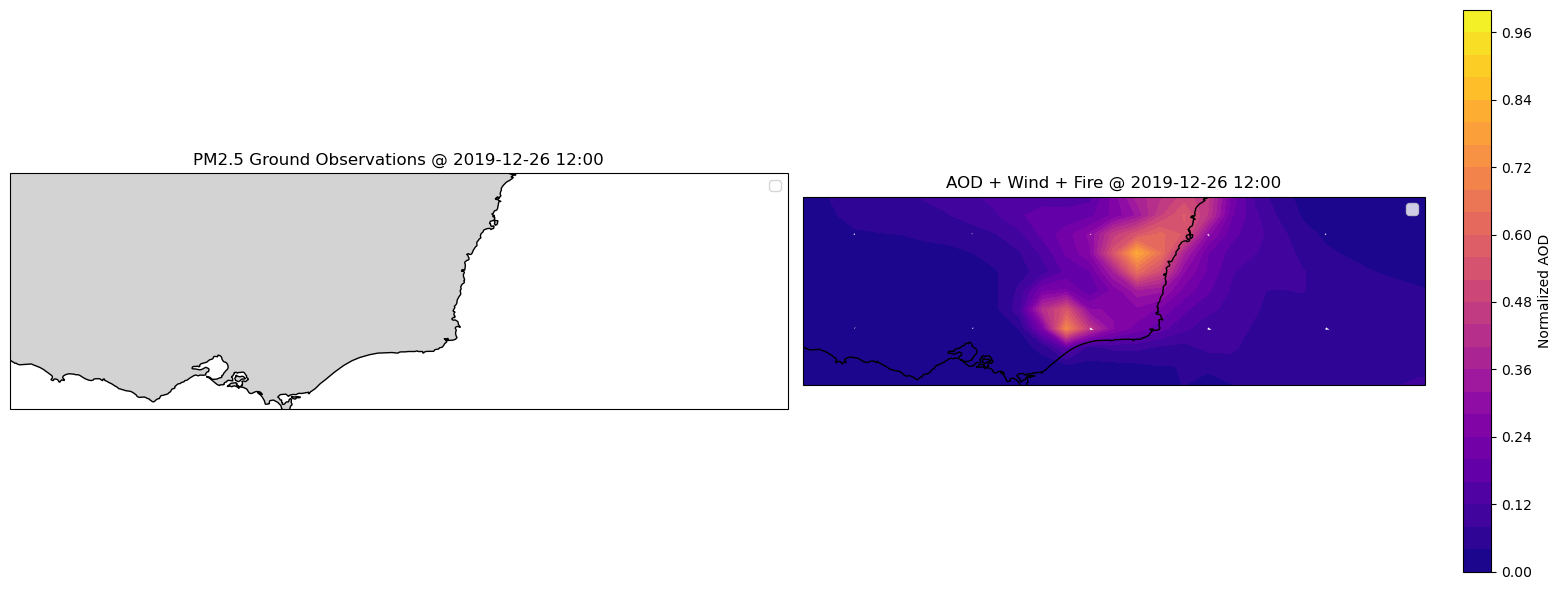

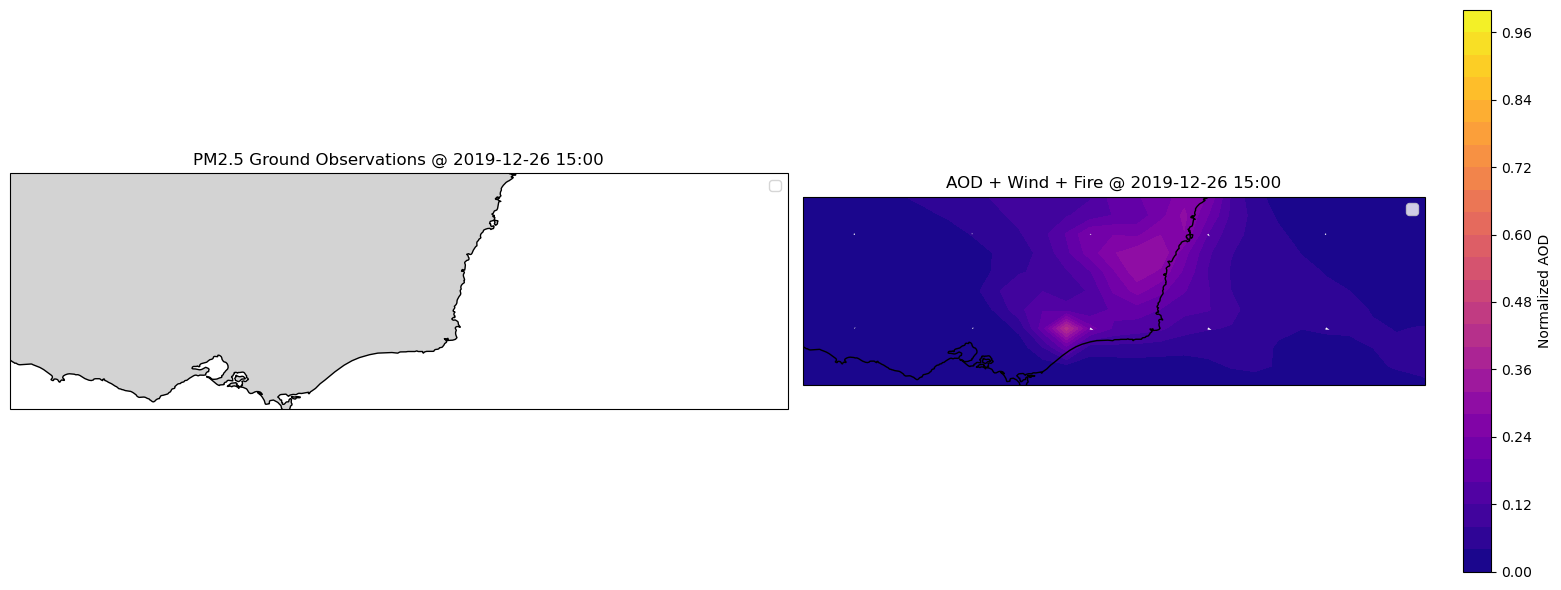

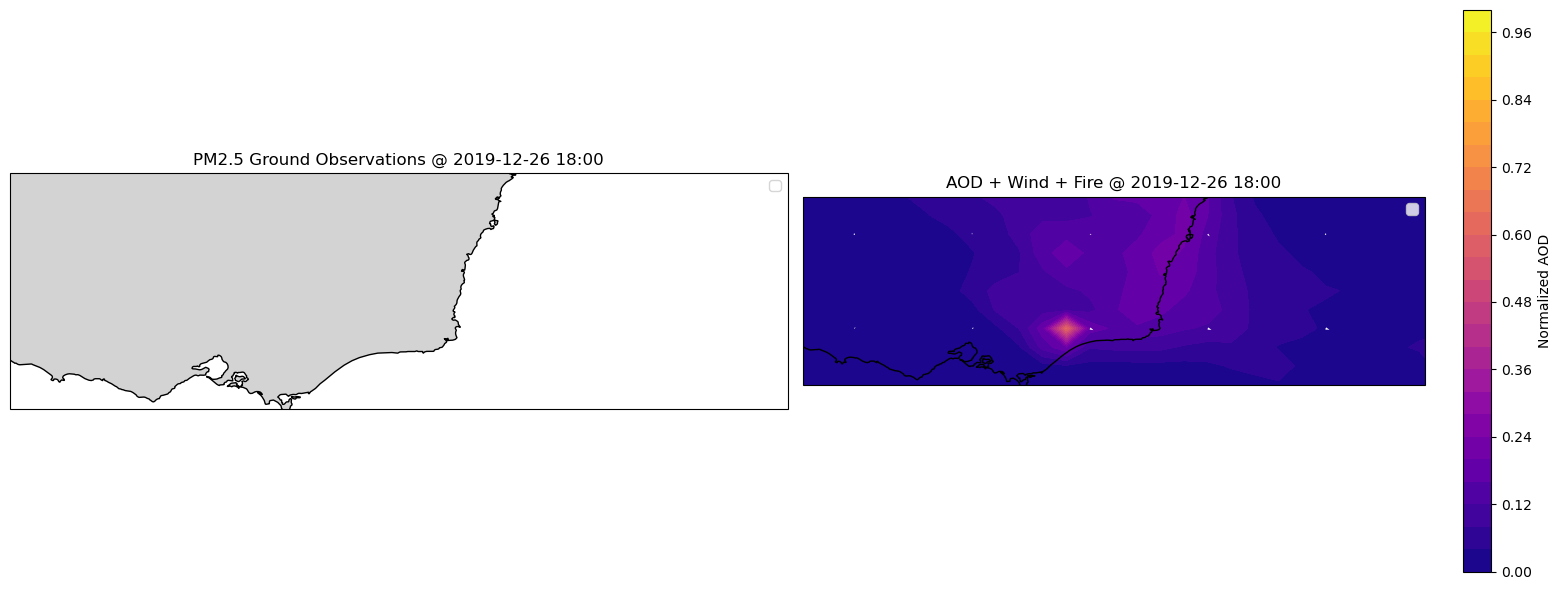

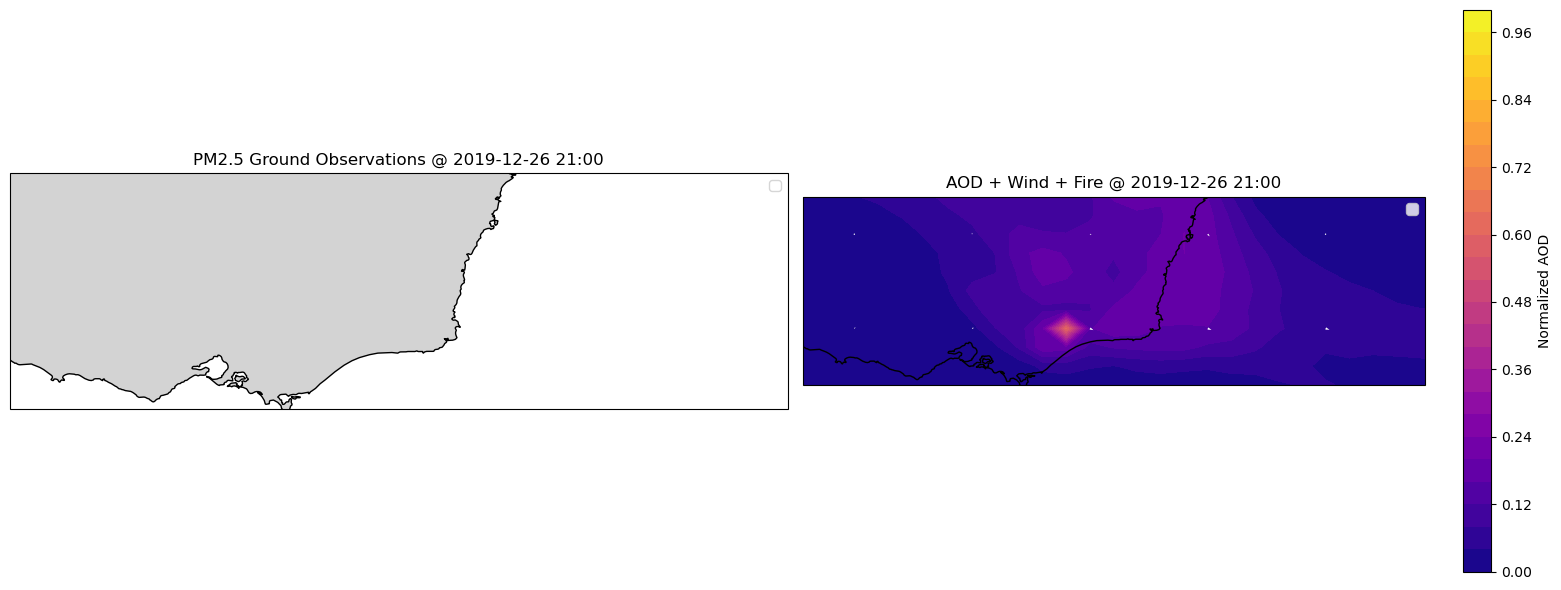

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: RuntimeWarning: invalid value encountered in cast
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: RuntimeWarning: invalid value encountered in cast
  wind_times = ds_wind.variables["time"][:]  # in hours
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  wind_times = ds_wind.variables["time"][:]  # in hours


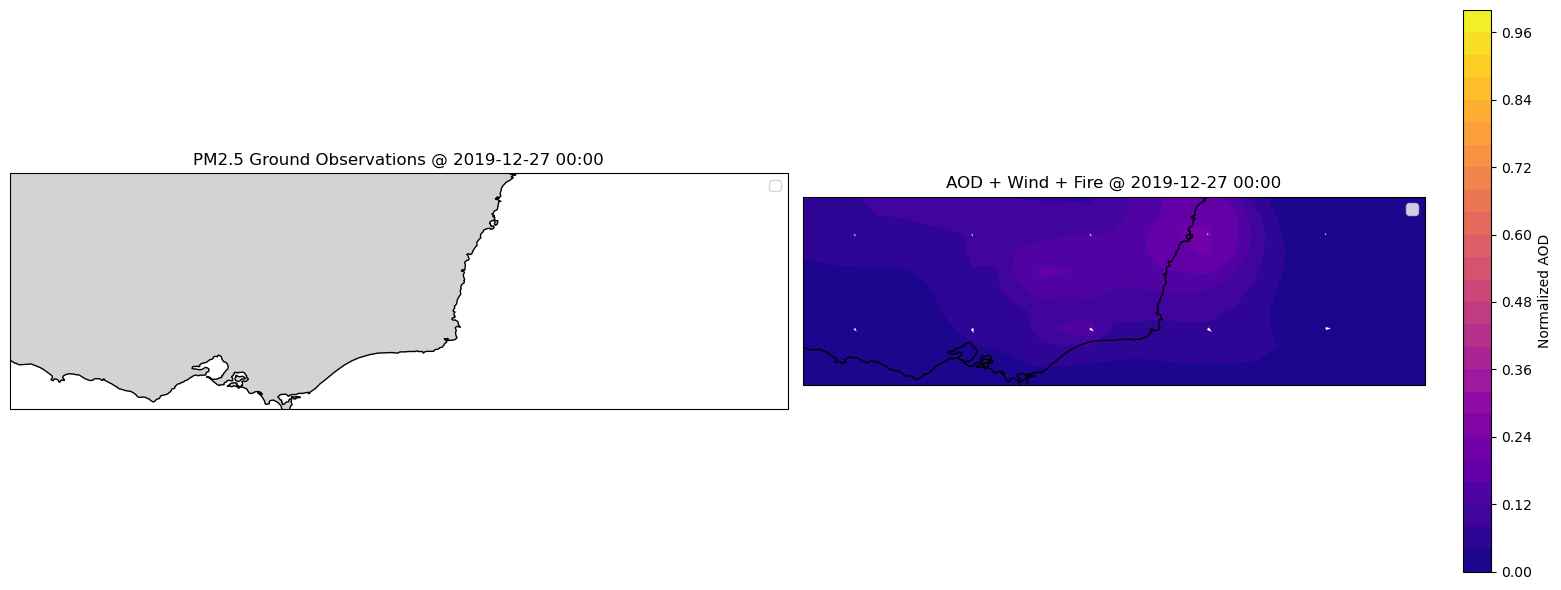

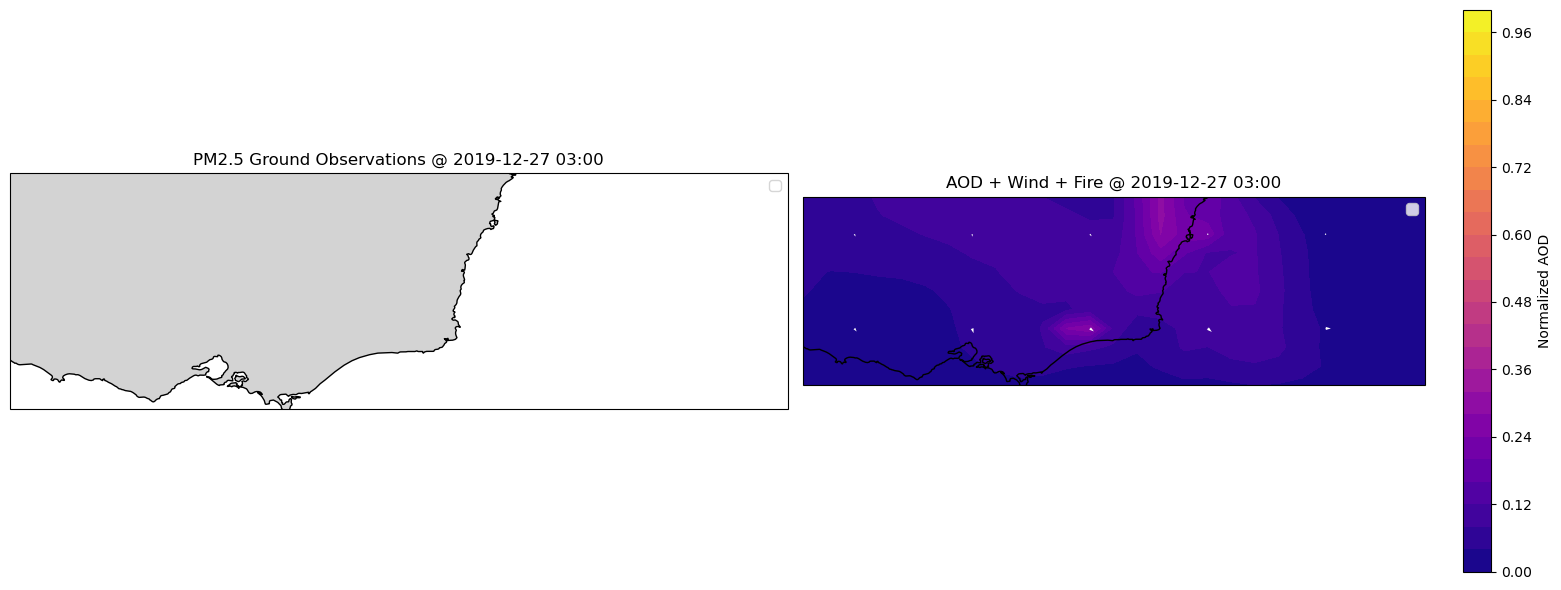

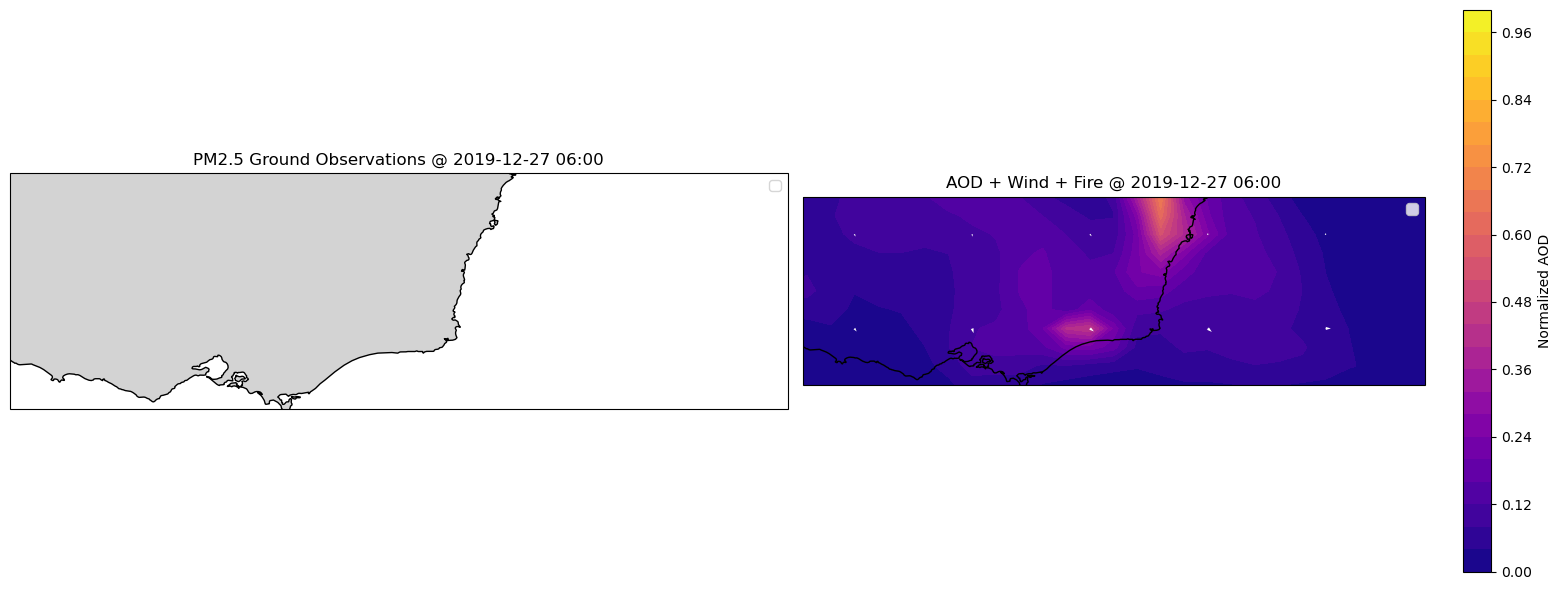

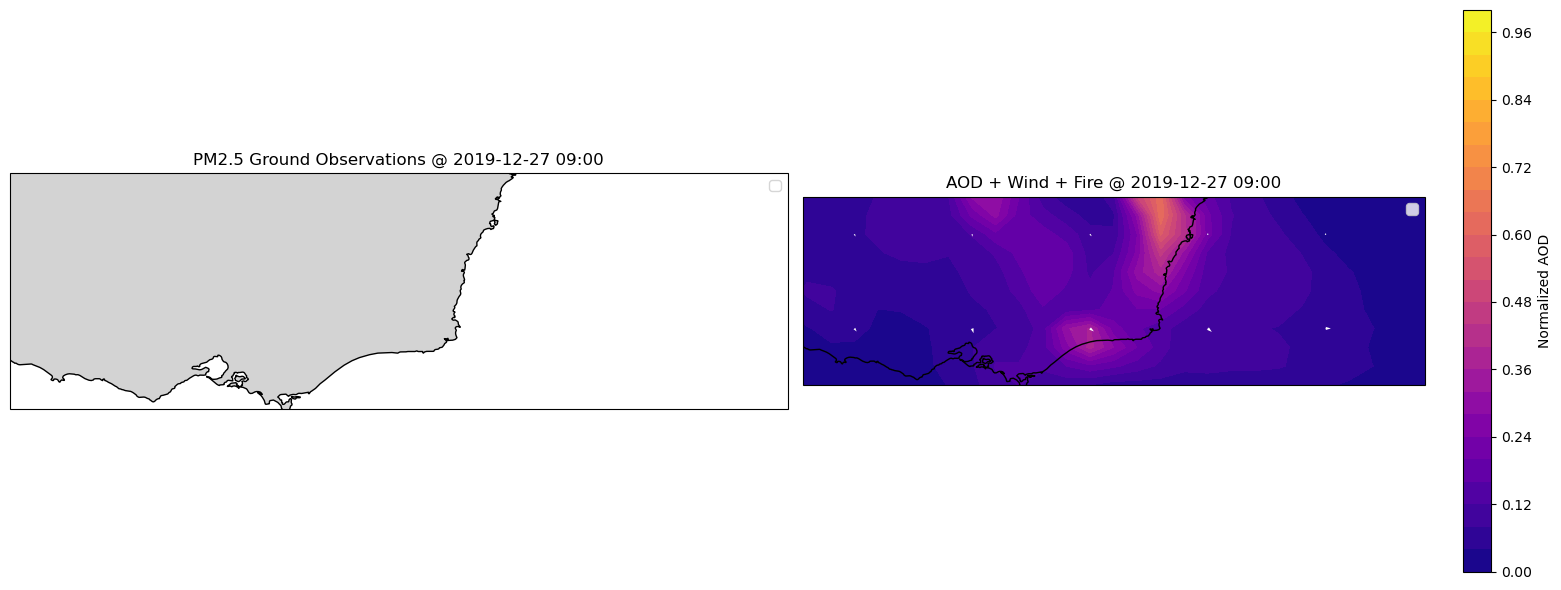

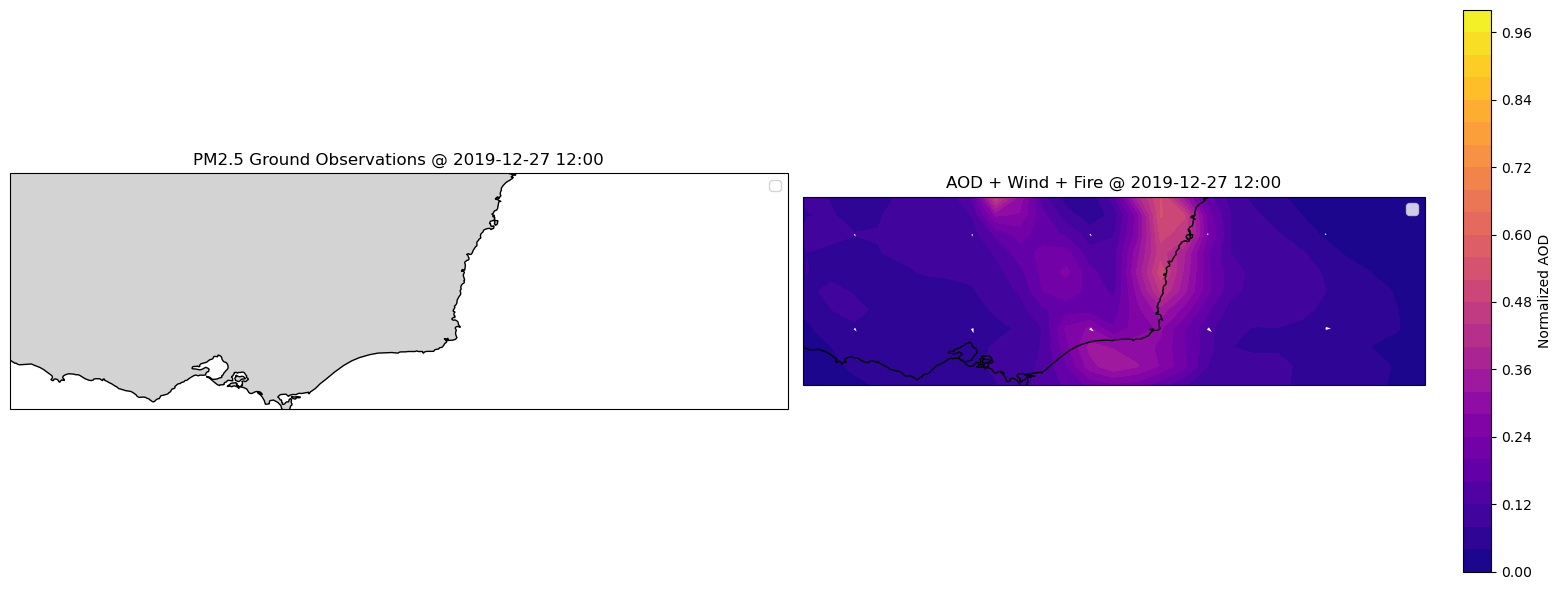

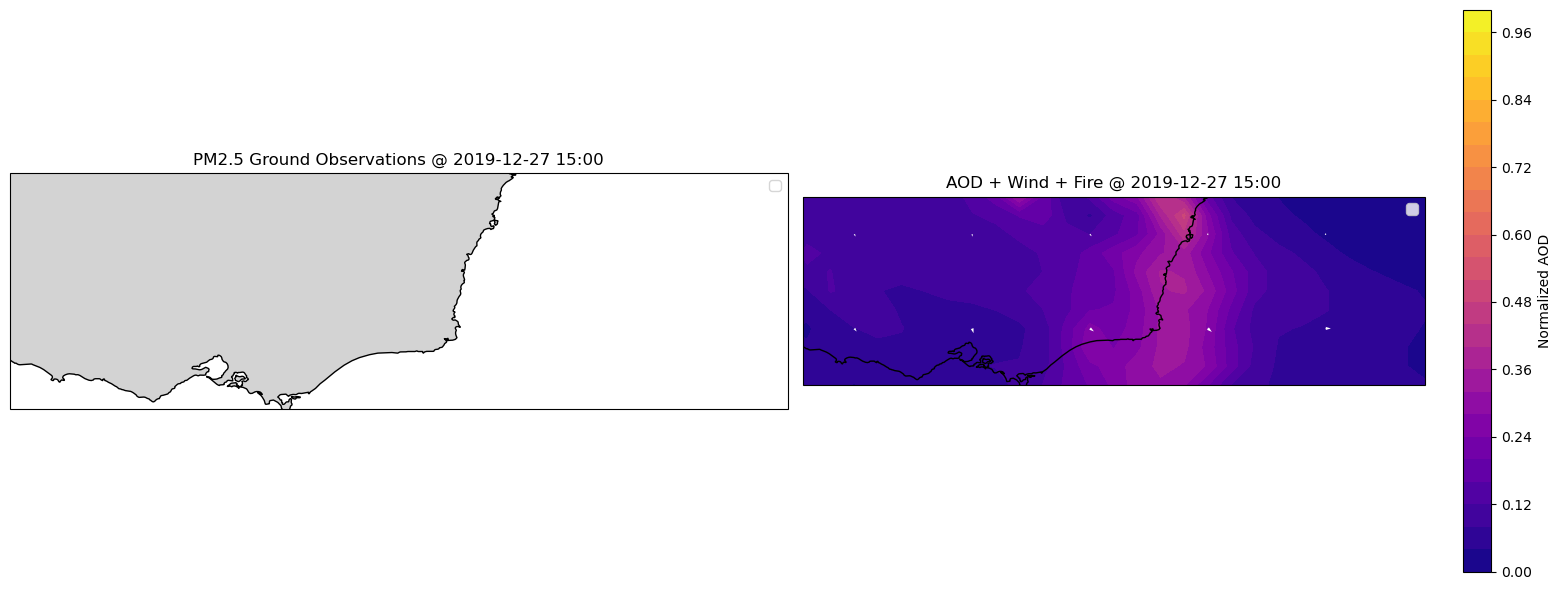

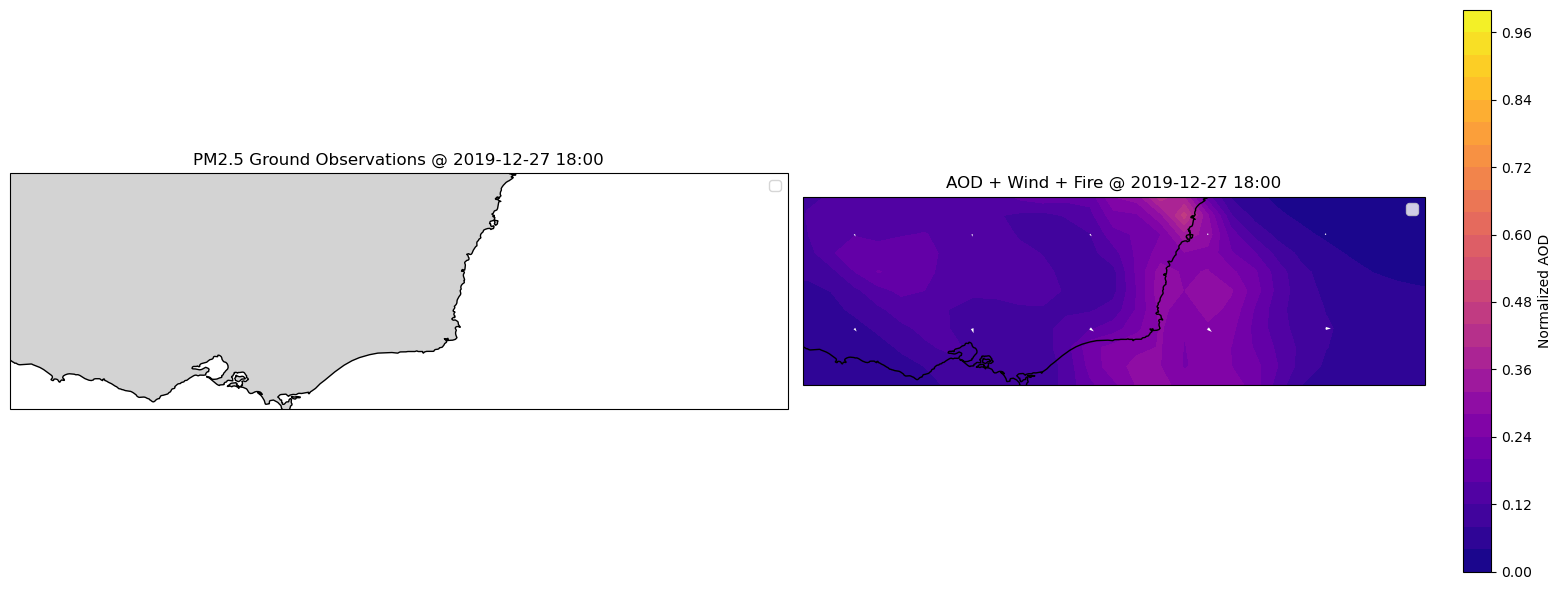

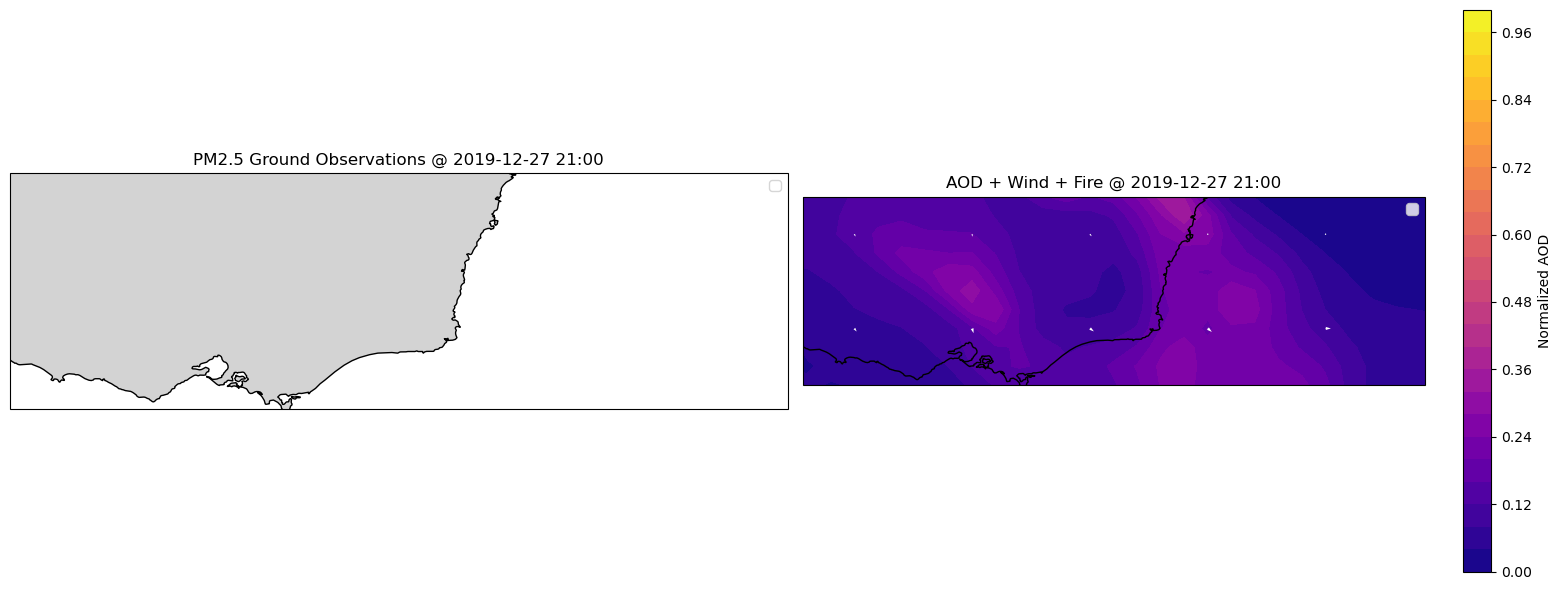

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: RuntimeWarning: invalid value encountered in cast
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: RuntimeWarning: invalid value encountered in cast
  wind_times = ds_wind.variables["time"][:]  # in hours
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  wind_times = ds_wind.variables["time"][:]  # in hours


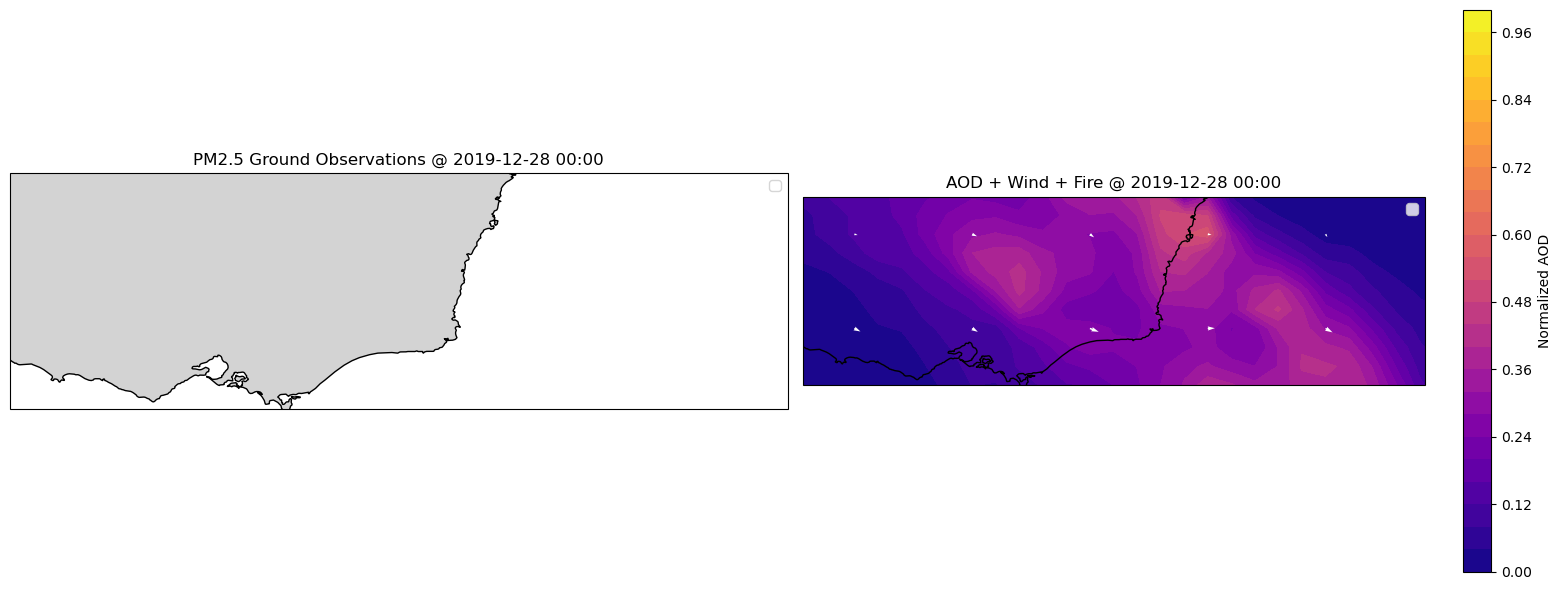

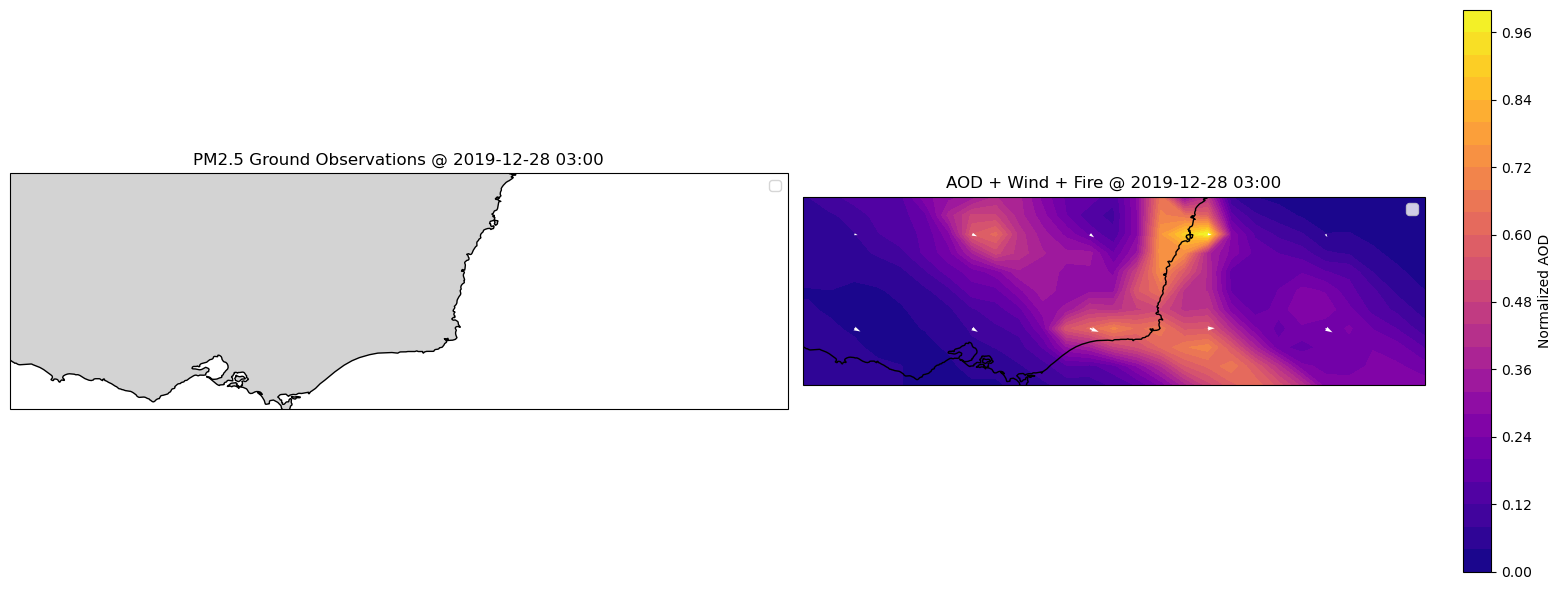

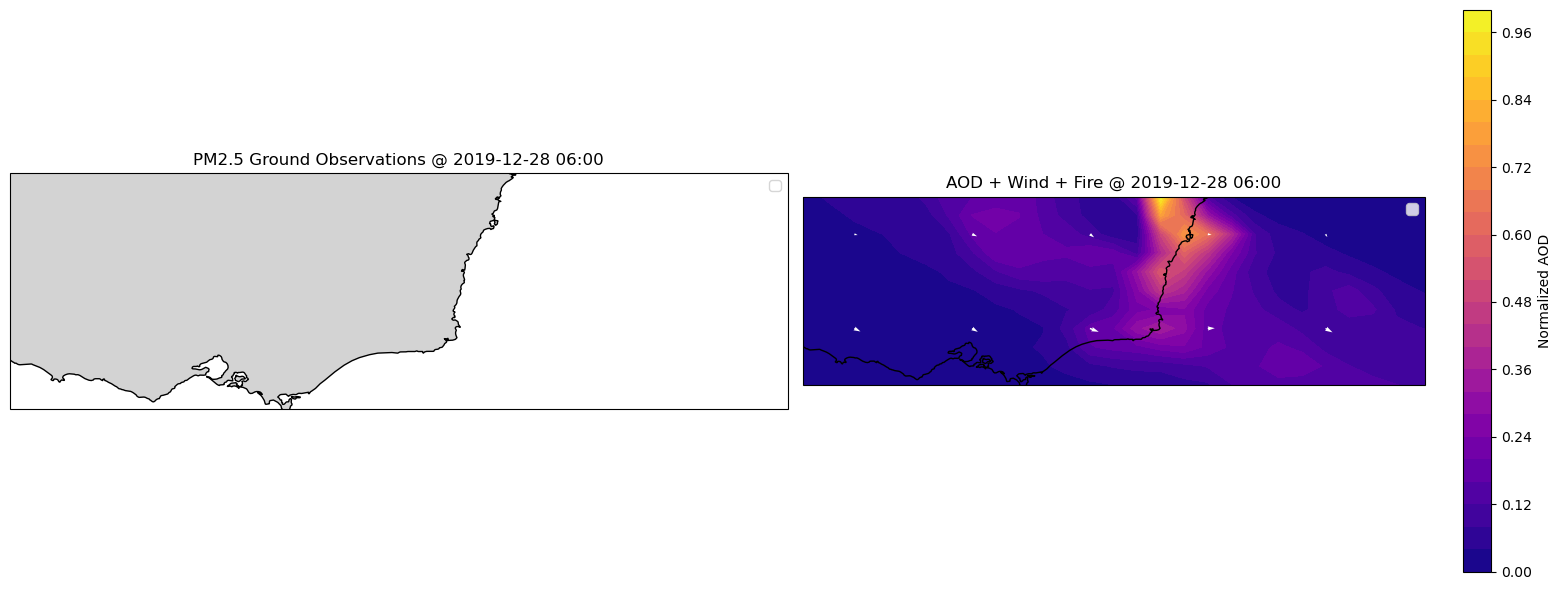

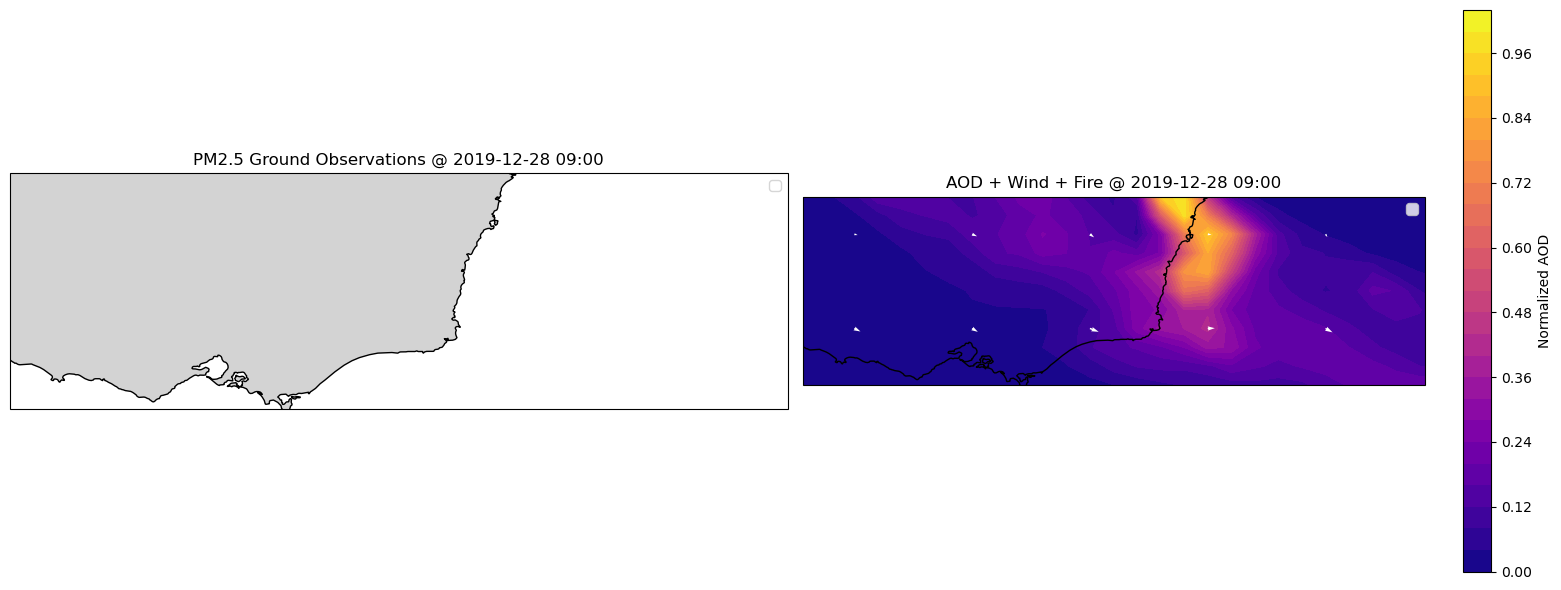

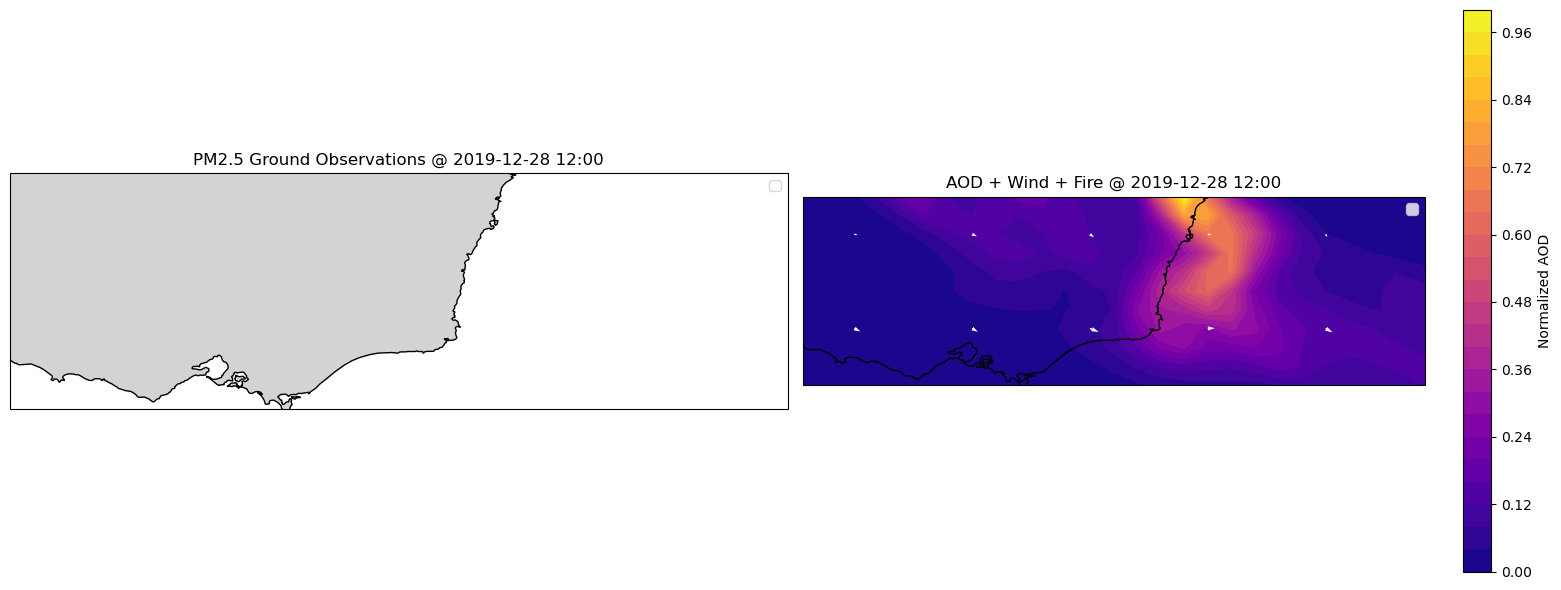

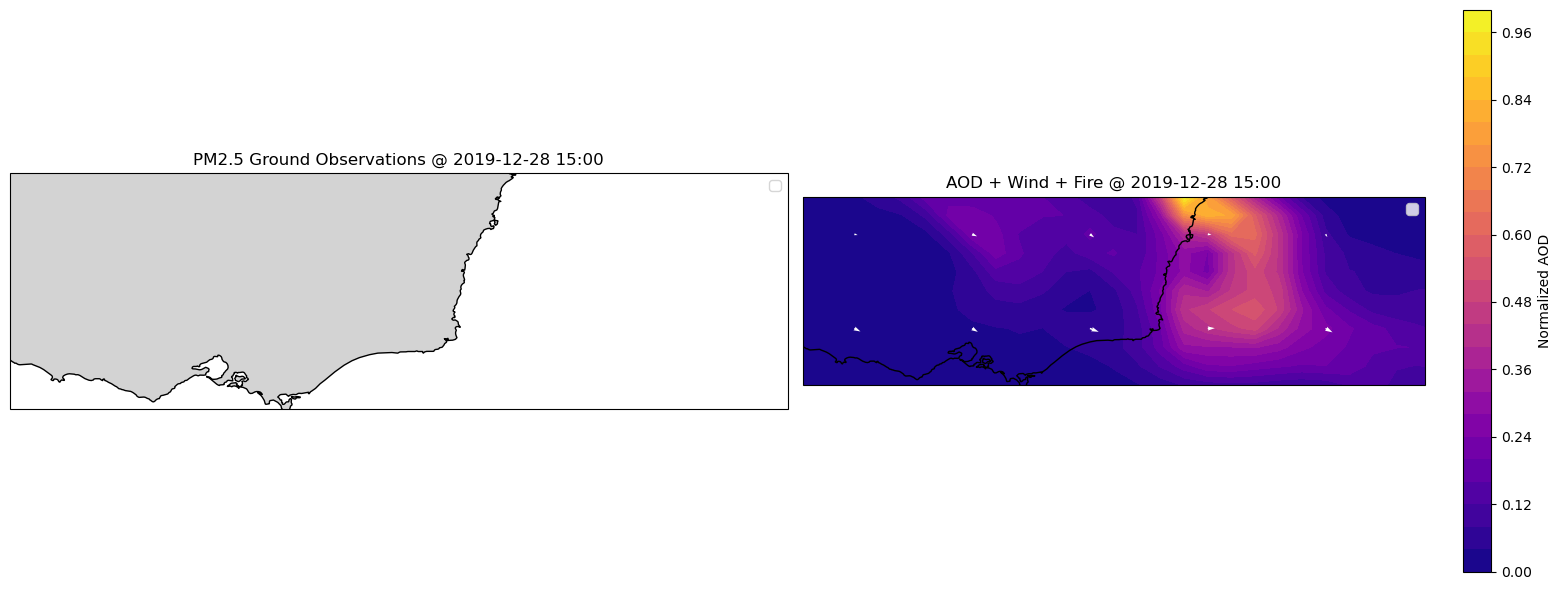

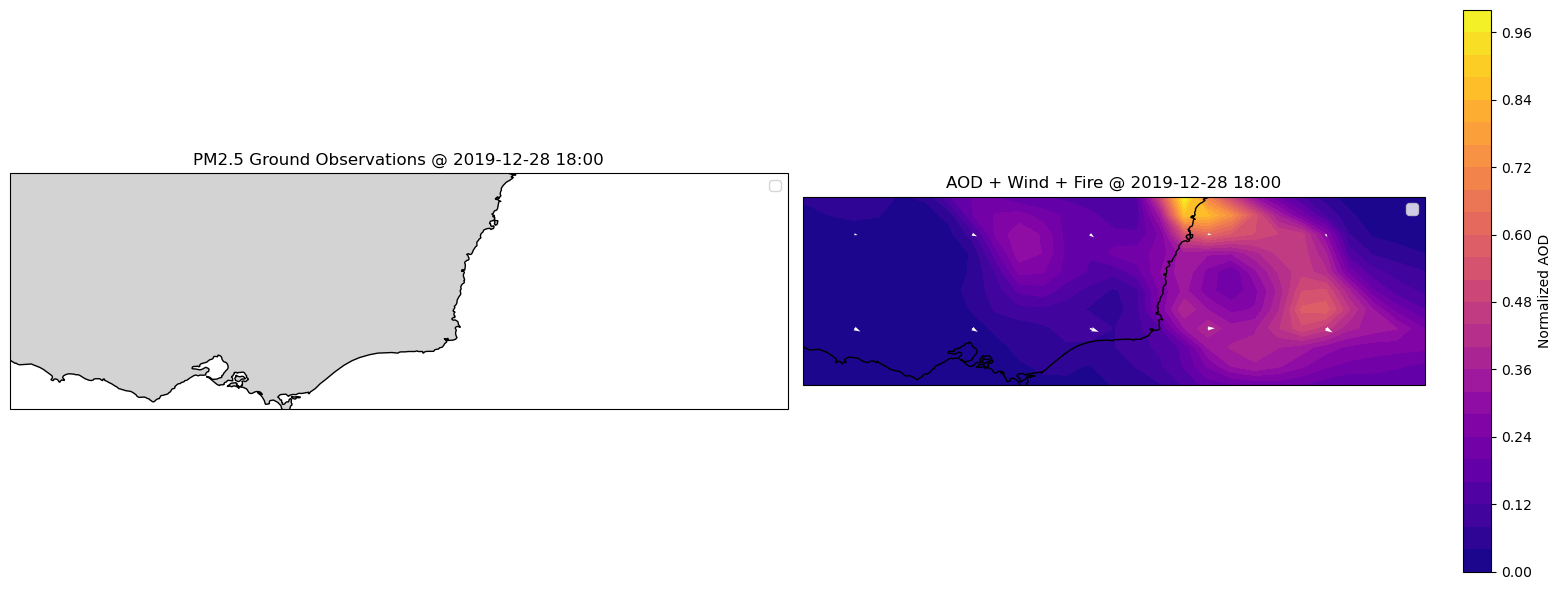

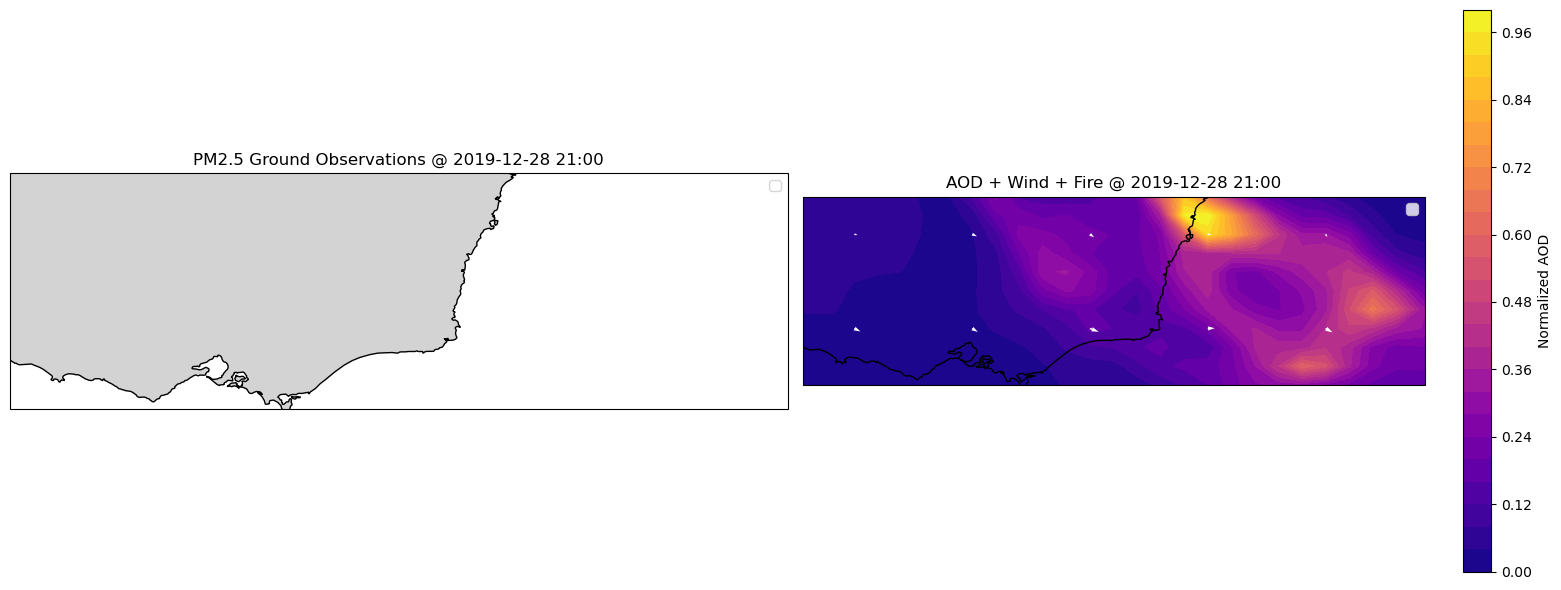

C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: RuntimeWarning: invalid value encountered in cast
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:60: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = ds_aod.variables["time"][:]   # in minutes
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: RuntimeWarning: invalid value encountered in cast
  wind_times = ds_wind.variables["time"][:]  # in hours
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_18788\1609341496.py:71: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  wind_times = ds_wind.variables["time"][:]  # in hours


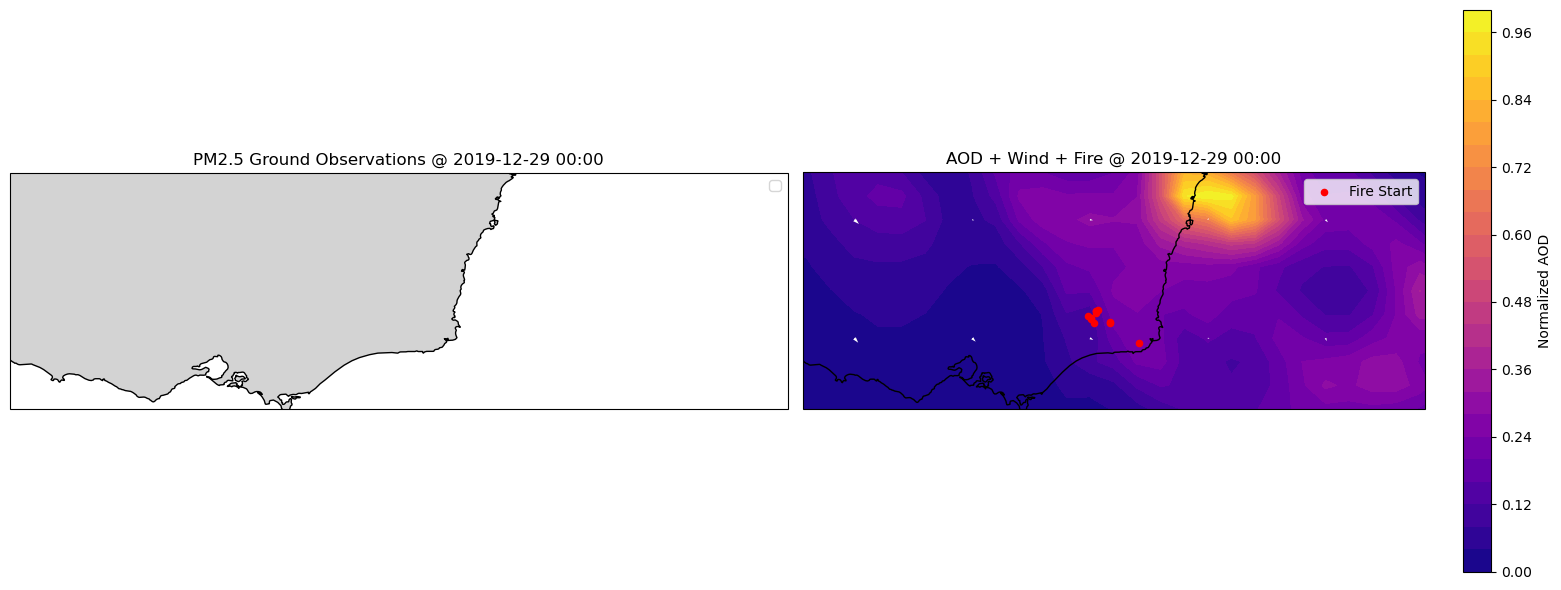

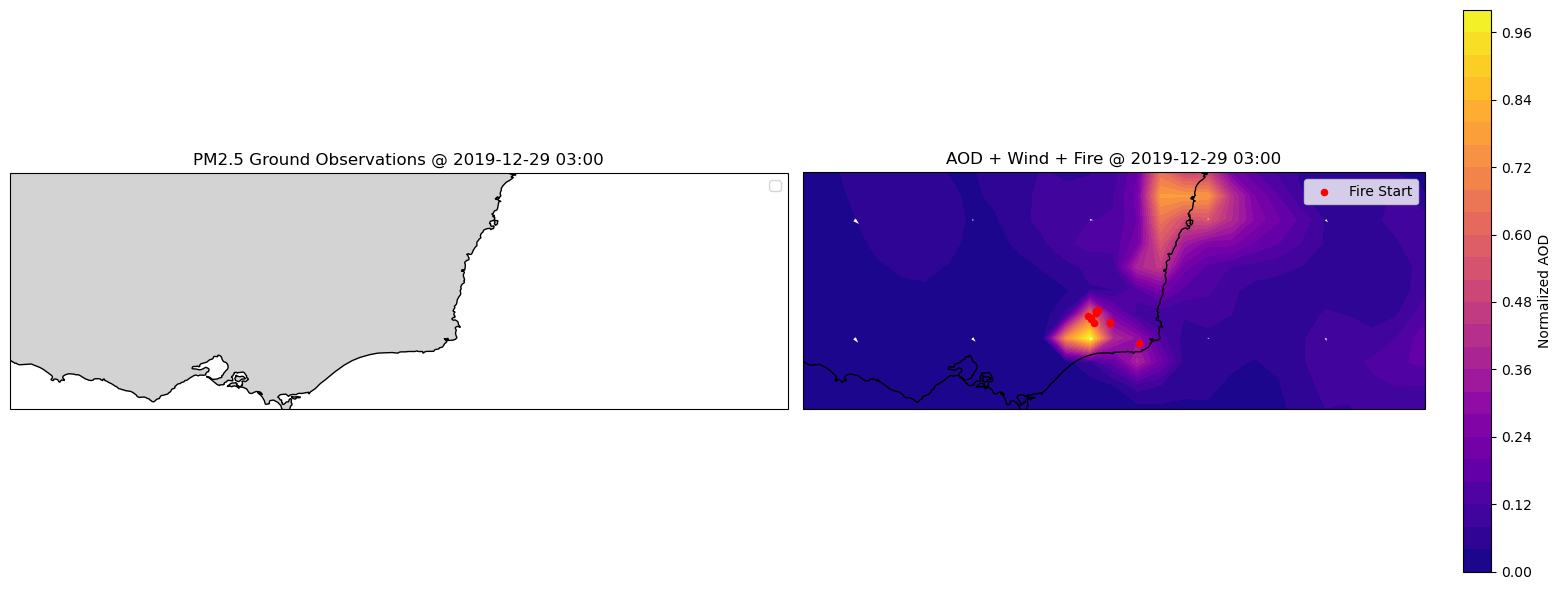

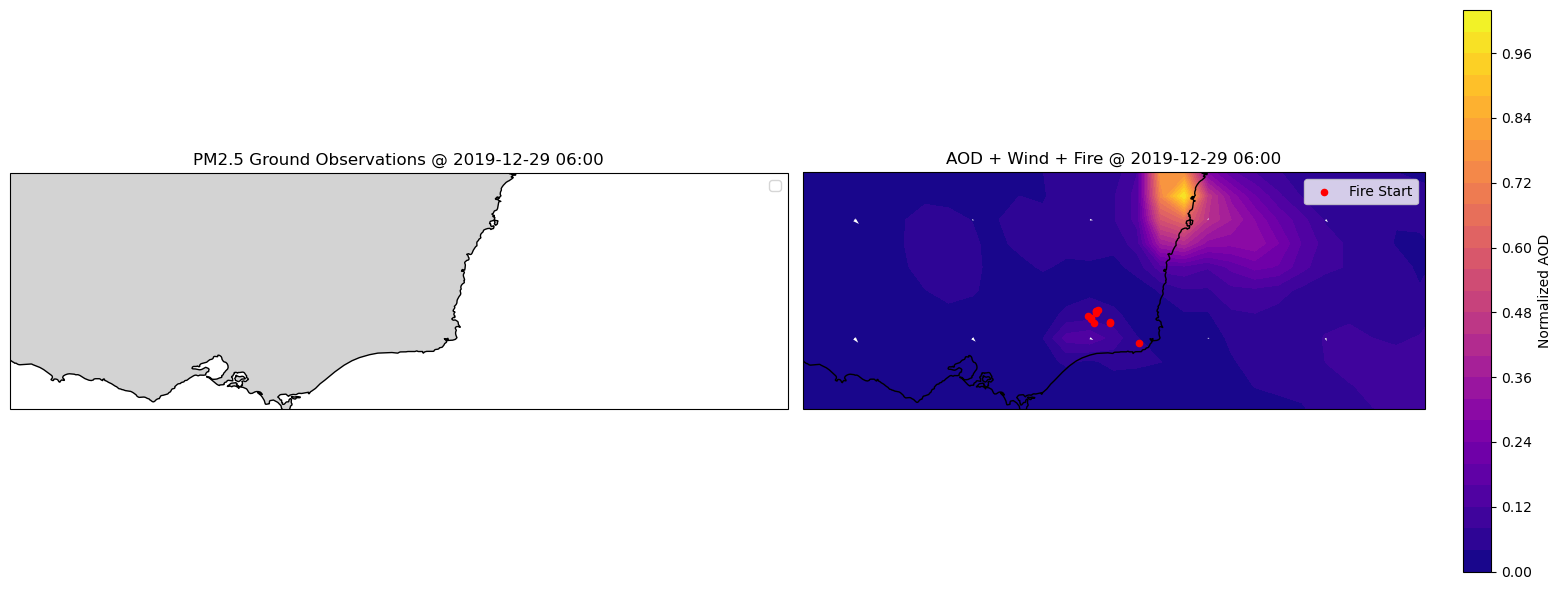

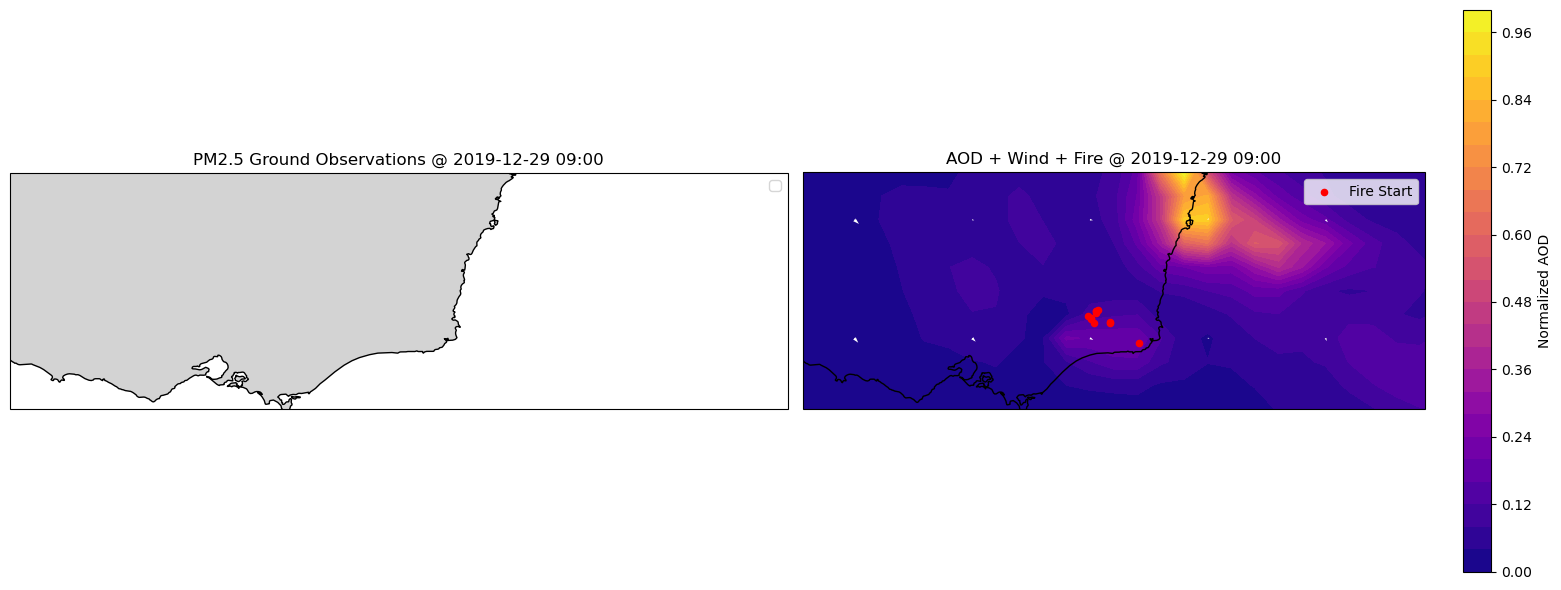

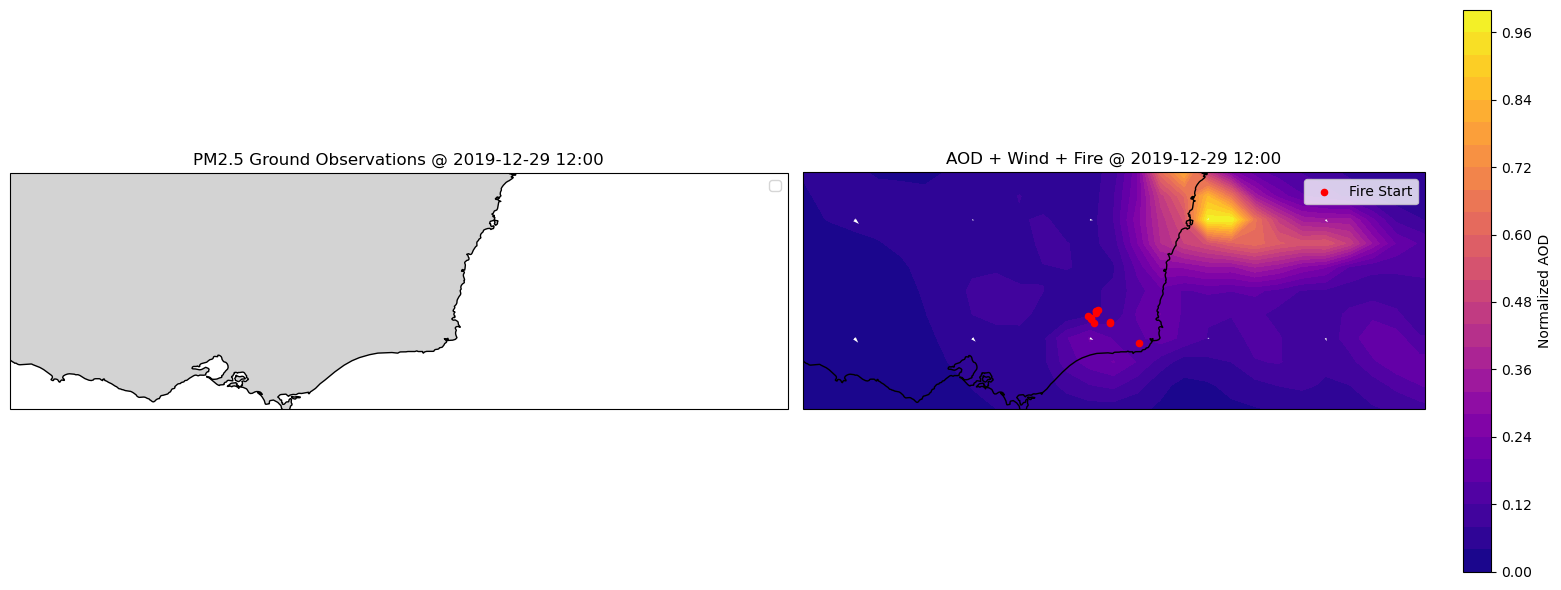

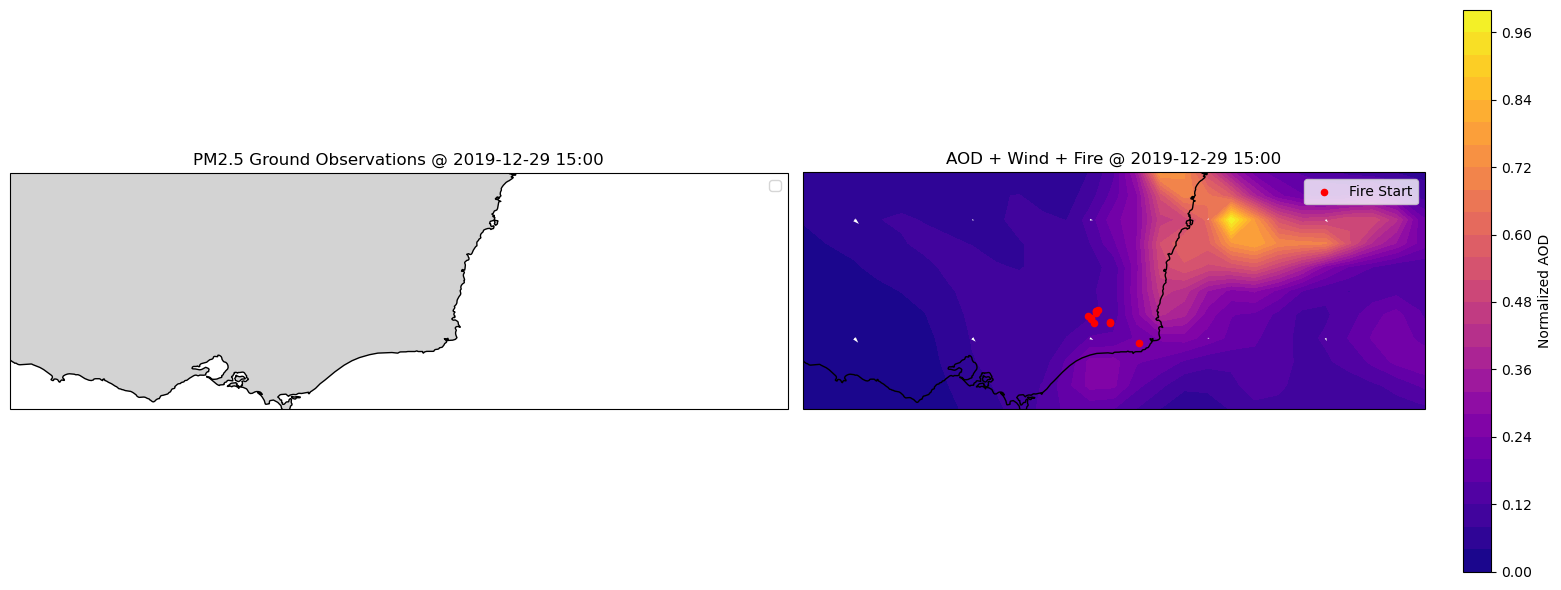

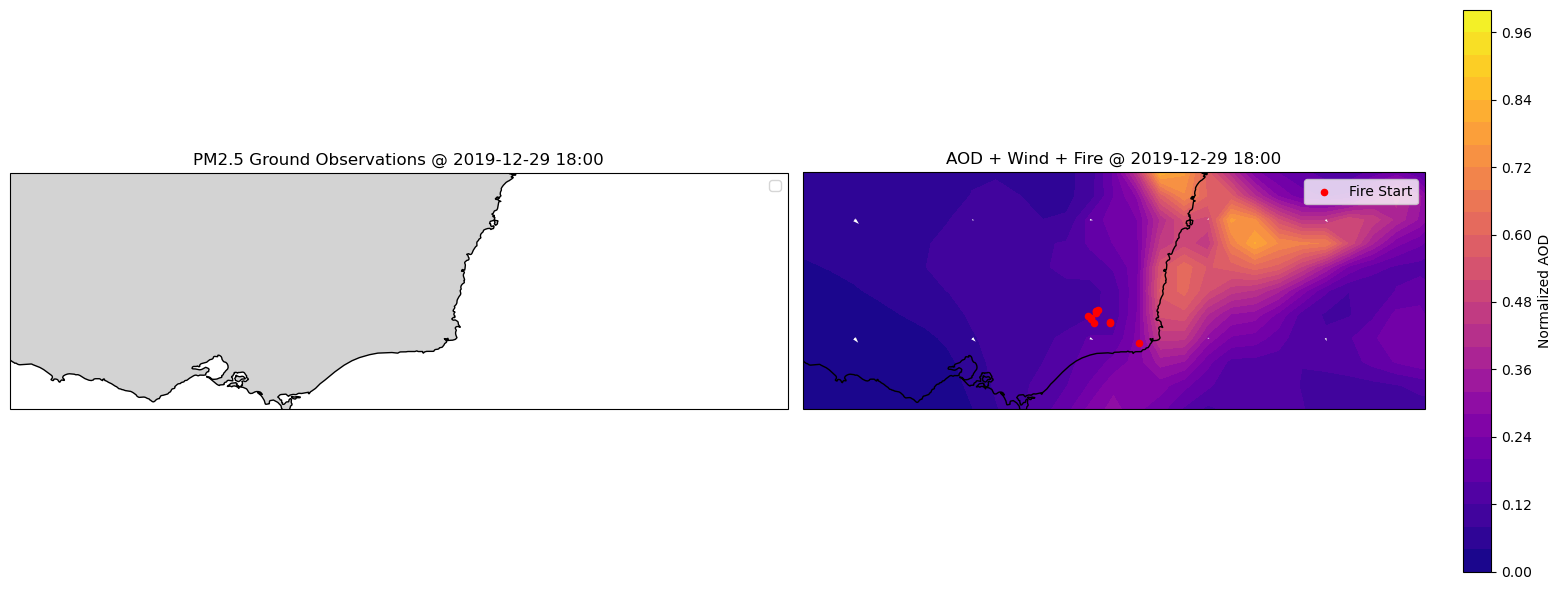

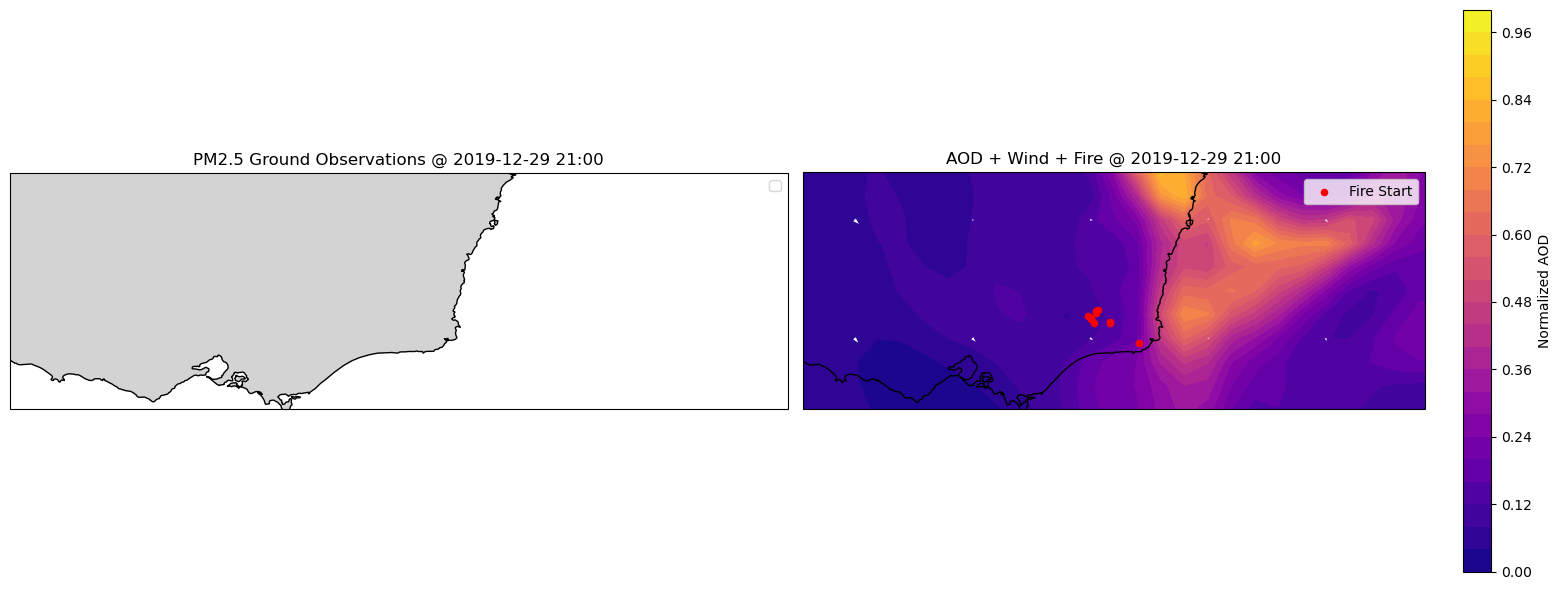

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd

# === Fire shapefile ===
fire_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Order_CD850U\mga94_54\esrishape\cma100\East Gippsland-0\FIRE\FIRE_HISTORY_ORIGIN.shp"
gdf = gpd.read_file(fire_path)
gdf = gdf.to_crs(epsg=4326)  # convert to lat/lon

# === Filter fires between Dec 2019 and Jan 2020 ===
gdf['FIRE_START'] = pd.to_datetime(gdf['FIRE_START'], errors='coerce')
filtered_fires = gdf[
    (gdf['FIRE_START'] >= '2019-12-25') & 
    (gdf['FIRE_START'] <= '2020-01-05')
]

# === AOD data config ===
start_date = datetime(2019, 12, 25)
num_days = 5
folder_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD"
file_template = "MERRA2_400.inst3_2d_gas_Nx.{}.nc4"

# === Wind Visualization Overlay ===
wind_folder_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\Wind"
wind_template = "MERRA2_400.tavg3_3d_asm_Nv.{}.nc4"
layer = 60
step = 5

#=== Sourcemean ===
from pyproj import Transformer

# Convert UTM boundary to lat/lon using pyproj
proj_utm = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
transformer = Transformer.from_proj(proj_utm, "epsg:4326", always_xy=True)

(tmin, xmin, ymin), (tmax, xmax, ymax) = boundary
lon_min, lat_min = transformer.transform(xmin, ymin)
lon_max, lat_max = transformer.transform(xmax, ymax)

lat_bins = np.linspace(lat_min, lat_max, sourcemean.shape[1])
lon_bins = np.linspace(lon_min, lon_max, sourcemean.shape[2])
lon_grid_source, lat_grid_source = np.meshgrid(lon_bins, lat_bins)

# === Loop through AOD files ===
for day_offset in range(num_days):
    date = start_date + timedelta(days=day_offset)
    date_str = date.strftime('%Y%m%d')

    # Load AOD
    aod_path = os.path.join(folder_path, file_template.format(date_str))
    if not os.path.exists(aod_path): continue
    ds_aod = Dataset(aod_path)
    aod_data = ds_aod.variables["AODANA"][:]  # shape (8, 361, 576)
    aod_times = ds_aod.variables["time"][:]   # in minutes
    aod_lats = ds_aod.variables["lat"][:]
    aod_lons = ds_aod.variables["lon"][:]
    aod_lon_grid, aod_lat_grid = np.meshgrid(aod_lons, aod_lats)

    # Load wind
    wind_path = os.path.join(wind_folder_path, wind_template.format(date_str))
    if not os.path.exists(wind_path): continue
    ds_wind = Dataset(wind_path)
    wind_lats = ds_wind.variables["lat"][:]
    wind_lons = ds_wind.variables["lon"][:]
    wind_times = ds_wind.variables["time"][:]  # in hours
    U = ds_wind.variables["U"][:, layer, :, :]
    V = ds_wind.variables["V"][:, layer, :, :]
    wind_lon_grid, wind_lat_grid = np.meshgrid(wind_lons, wind_lats)
    
    # Prevent duplicate legends
    # handles, labels = ax2.get_legend_handles_labels()
    # unique_labels = dict(zip(labels, handles))
    # ax2.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')

    for t_index in range(aod_data.shape[0]):
        timestamp = date + timedelta(minutes=int(aod_times[t_index]))
        current_date = timestamp.date()

        # Find nearest wind index by time (convert AOD minutes to hours)
        wind_time_diff = np.abs(wind_times * 60 - aod_times[t_index])
        wind_index = np.argmin(wind_time_diff)

        # Prepare slices
        aod_slice = np.nan_to_num(aod_data[t_index], nan=0.0)
        norm_aod = (aod_slice - np.min(aod_slice)) / (np.max(aod_slice) + 1e-6)
        u_slice = U[wind_index][::step, ::step]
        v_slice = V[wind_index][::step, ::step]
        lon_sub = wind_lon_grid[::step, ::step]
        lat_sub = wind_lat_grid[::step, ::step]

        # Fires on this day
        daily_fires = filtered_fires[filtered_fires['FIRE_START'].dt.date == current_date]

        # === Plot ===
        # === Plot side-by-side ===
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        
       # === LEFT: PM2.5 Ground Observations ===
        ax1 = axes[0]
        ax1.set_extent([140.5, 157, -39, -34])
        ax1.add_feature(cfeature.COASTLINE)
        ax1.add_feature(cfeature.BORDERS)
        ax1.add_feature(cfeature.LAND, facecolor='lightgray')
        ax1.set_title(f"PM2.5 Ground Observations @ {timestamp.strftime('%Y-%m-%d %H:%M')}")
        
        # Filter PM2.5 for this datetime
        pm25_time_filtered = pm25_df[pm25_df['sample_datetime'].dt.date == current_date]
        
        for _, row in pm25_time_filtered.iterrows():
            ax1.scatter(row['longitude'], row['latitude'],
                        s=row['value'] * 3,
                        color='blue', alpha=0.7,
                        transform=ccrs.PlateCarree(),
                        label=f"{row['sp_name']} ({row['value']} µg/m³)")
        
        # Remove duplicate legend entries
        handles1, labels1 = ax1.get_legend_handles_labels()
        unique_labels1 = dict(zip(labels1, handles1))
        ax1.legend(unique_labels1.values(), unique_labels1.keys(), loc='upper right')


        
        # === RIGHT: AOD + Wind + Fire ===
        ax2 = axes[1]
        ax2.set_extent([140.5, 157, -39, -34])
        ax2.add_feature(cfeature.COASTLINE)
        ax2.add_feature(cfeature.BORDERS)
        ax2.add_feature(cfeature.LAND, facecolor='lightgray')
        
        cf2 = ax2.contourf(aod_lon_grid, aod_lat_grid, norm_aod, levels=30, cmap='plasma', transform=ccrs.PlateCarree())
        fig.colorbar(cf2, ax=ax2, orientation='vertical', label='Normalized AOD')
        ax2.quiver(lon_sub, lat_sub, u_slice, v_slice, transform=ccrs.PlateCarree(), color='white', scale=1000)
        
        if not daily_fires.empty:
            daily_fires.plot(ax=ax2, color='red', markersize=20, label='Fire Start')
            ax2.legend(loc='lower right')
        
        ax2.set_title(f"AOD + Wind + Fire @ {timestamp.strftime('%Y-%m-%d %H:%M')}")
        # PM2.5 overlay — filter only those with matching datetime
        pm25_time_filtered = pm25_df[pm25_df['sample_datetime'].dt.date == current_date]
        
        # Plot PM2.5 readings
        for _, row in pm25_time_filtered.iterrows():
            ax2.scatter(row['longitude'], row['latitude'],
                        s=row['value'] * 3,
                        color='blue', alpha=0.7,
                        transform=ccrs.PlateCarree(),
                        label=f"{row['sp_name']} ({row['value']} µg/m³)")
        
        # Prevent duplicate legends
        handles, labels = ax2.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))
        ax2.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')
        plt.tight_layout()
        plt.show()

    ds_aod.close()
    ds_wind.close()
        



In [64]:
print(pm25_time_filtered[['sp_name', 'latitude', 'longitude', 'value']])


Empty DataFrame
Columns: [sp_name, latitude, longitude, value]
Index: []
